In [48]:
from astropy.table import Table
import warnings
warnings.filterwarnings("ignore")

def SimulateFIREBallemCCDImage(
    conv_gain=0.53, EmGain=1500, Bias="Auto", RN=80, p_pCIC=0.0005, p_sCIC=0, Dark=5e-4, Smearing=0.7, SmearExpDecrement=50000, exposure=50, flux=1e-3, source="Slit", Rx=8, Ry=8, size=[100, 100], OSregions=[0, -1], name="Auto", spectra="-", cube="-", n_registers=604, sky=0,save=False,stack=1,readout_time=1.5, cosmic_ray_loss=None, counting=True, QE=0.45, field="targets_F2.csv",QElambda=True,atmlambda=True,fraction_lya=0.05):
    #%%
    # ConversionGain=0.53
    # EmGain=1500
    # Bias="Auto"
    # RN=80 
    # p_pCIC=0.0005
    # p_sCIC=0
    # Dark=0.5/3600
    # Smearing=0.7
    # SmearExpDecrement=50000
    # exposure=50
    # flux=1e-3
    # source="Field"
    # Rx=4
    # Ry=4
    # name="Auto"
    # n_registers=604
    # sky=0
    # save=False
    # stack=stack=1#int(3600*1/50)
    # readout_time=1.5
    # cosmic_ray_loss=None
    # size=[1058, 2069]
    # OSregions=[0, 1058]

    # size=[3216, 2069]
    # OSregions=[1066, 2124]
    # EmGain=1500; Bias=0; RN=80; p_pCIC=1; p_sCIC=0; Dark=1/3600; Smearing=1; SmearExpDecrement=50000; exposure=50; flux=1; sky=4; source="Spectra m=17"; Rx=8; Ry=8;  size=[100, 100]; OSregions=[0, 120]; name="Auto"; spectra="Spectra m=17"; cube="-"; n_registers=604; save=False;readout_time=5;stack=100;QE=0.5
    from astropy.modeling.functional_models import Gaussian2D, Gaussian1D
    from scipy.sparse import dia_matrix
    from scipy.interpolate import interp1d


    OS1, OS2 = OSregions
    # ConversionGain=1
    ConversionGain = conv_gain
    Bias=0
    image = np.zeros((size[1], size[0]), dtype="float64")
    image_stack = np.zeros((size[1], size[0]), dtype="float64")

    # dark & flux
    source_im = 0 * image[:, OSregions[0] : OSregions[1]]
    source_im_wo_atm = 0 * image[:, OSregions[0] : OSregions[1]]
    lx, ly = source_im.shape
    y = np.linspace(0, lx - 1, lx)
    x = np.linspace(0, ly - 1, ly)
    x, y = np.meshgrid(x, y)

    # Source definition. For now the flux is not normalized at all, need to fix this
    # Cubes still needs to be implememted, link to detector model or putting it here?
    # if os.path.isfile(cube):
    throughput = 0.13*0.9
    atm = 0.45
    area = 7854
    dispersion = 46.6/10
    wavelength=2000
            #%%
    if source == "Flat-field":
        source_im += flux
    elif source == "Dirac":
        source_im += Gaussian2D.evaluate(x, y,  flux, ly / 2, lx / 2, Ry, Rx, 0)
    elif "Spectra" in source:
        if "mNUV=" not in source:
            # for file in glob.glob("/Users/Vincent/Downloads/FOS_spectra/FOS_spectra_for_FB/CIV/*.fits"):
            try:
                a = Table.read("Spectra/h_%sfos_spc.fits"%(source.split(" ")[1]))
                slits = None#Table.read("Targets/2022/" + field).to_pandas()
                trans = Table.read("transmission_pix_resolution.csv")
                QE = Table.read("QE_2022.csv")
            except FileNotFoundError: 
                a = Table.read("/Users/Vincent/Github/notebooks/Spectra/h_%sfos_spc.fits"%(source.split(" ")[-1]))
                slits = Table.read("/Users/Vincent/Github/FireBallPipe/Calibration/Targets/2022/" + field).to_pandas()
                trans = Table.read("/Users/Vincent/Github/FIREBall_IMO/Python Package/FireBallIMO-1.0/FireBallIMO/transmission_pix_resolution.csv")
                QE = Table.read("/Users/Vincent/Github/FIREBall_IMO/Python Package/FireBallIMO-1.0/FireBallIMO/PSFDetector/efficiencies/QE_2022.csv")
            QE = interp1d(QE["wave"]*10,QE["QE_corr"])#
            trans["trans_conv"] = np.convolve(trans["col2"],np.ones(5)/5,mode="same")
            trans = trans[:-5]
            atm_trans =  interp1d([1500,2500]+list(trans["col1"]*10),[0,0] + list(trans["trans_conv"]))#

            a["photons"] = a["FLUX"]/9.93E-12   
            a["e_pix_sec"]  = a["photons"] * throughput * atm  * area /dispersion
            nsize,nsize2 = 100,500
            source_im=np.zeros((nsize,nsize2))
            source_im_wo_atm=np.zeros((nsize2,nsize))
            mask = (a["WAVELENGTH"]>1960) & (a["WAVELENGTH"]<2280)
            lmax = a["WAVELENGTH"][mask][np.argmax( a["e_pix_sec"][mask])]
            # plt.plot( a["WAVELENGTH"],a["e_pix_sec"])
            # plt.plot( a["WAVELENGTH"][mask],a["e_pix_sec"][mask])
            f = interp1d(a["WAVELENGTH"],a["e_pix_sec"])#
            profile =   Gaussian1D.evaluate(np.arange(nsize),  1,  nsize/2, Rx) /Gaussian1D.evaluate(np.arange(nsize),  1,  nsize/2, Rx).sum()
            subim = np.zeros((nsize2,nsize))
            wavelengths = np.linspace(lmax-nsize2/2/dispersion,lmax+nsize2/2/dispersion,nsize2)

            if 1==0:
                # source_im=np.zeros((100,100))
                # # plt.plot(a["WAVELENGTH"][mask],a["e_pix_exp"][mask])
                # profile =   Gaussian1D.evaluate(np.arange(100),  1,  50, Rx) /Gaussian1D.evaluate(np.arange(100),  1,  50, Rx).sum()
                # i = np.argmin(abs(a["WAVELENGTH"]-1960))
                # source_im[:,:] +=   profile
                # source_im = source_im.T*a["e_pix_sec"][i:i+100]
                
                
                fig,(ax0,ax1,ax2) = plt.subplots(3,1)
                ax0.fill_between(wavelengths, profile.max()*f(wavelengths),profile.max()* f(wavelengths) * atm_trans(wavelengths),label="Atmosphere impact",alpha=0.3)
                ax0.fill_between(wavelengths, profile.max()*f(wavelengths)* atm_trans(wavelengths)*QE(wavelengths),profile.max()* f(wavelengths) * atm_trans(wavelengths),label="QE impact",alpha=0.3)
                ax1.plot(wavelengths,f(wavelengths)/f(wavelengths).ptp(),label="Spectra")
                ax1.plot(wavelengths, f(wavelengths)* atm_trans(wavelengths)/(f(wavelengths)* atm_trans(wavelengths)).ptp(),label="Spectra * Atm")
                ax1.plot(wavelengths, f(wavelengths)* atm_trans(wavelengths)*QE(wavelengths)/( f(wavelengths)* atm_trans(wavelengths)*QE(wavelengths)).ptp(),label="Spectra * Atm * QE")
                ax2.plot(wavelengths,atm_trans(wavelengths) ,label="Atmosphere")
                ax2.plot(wavelengths,QE(wavelengths) ,label="QE")
                ax0.legend()
                ax1.legend()
                ax2.legend()
                ax0.set_ylabel("e/pix/sec")
                ax1.set_ylabel("Mornalized prof")
                ax2.set_ylabel("%")
                ax2.set_xlabel("wavelength")
                ax0.set_title(source.split(" ")[-1])
                fig.savefig("/Users/Vincent/Github/notebooks/Spectra/h_%sfos_spc.png"%(source.split(" ")[-1]))
                plt.show()
            QE = QE(wavelengths) if QElambda else QE(lmax) 
            atm_trans = atm_trans(wavelengths) if atmlambda else atm_trans(lmax) 
            source_im[:,:] +=  (subim+profile).T*f(wavelengths) * atm_trans * QE
            # source_im_wo_atm[:,:] +=  (subim+profile).T*f(wavelengths) #* atm_trans(wavelengths)
        else:
            #%%
            mag=float(source.split("mNUV=")[-1])
            factor_lya = fraction_lya
            flux = 10**(-(mag-20.08)/2.5)*2.06*1E-16/((6.62E-34*300000000/(wavelength*0.0000000001)/0.0000001))
            elec_pix = flux * throughput * atm * QE * area /dispersion# should not be multiplied by exposure time here
            with_line = elec_pix*(1-factor_lya) + factor_lya * (3700/1)*elec_pix* Gaussian1D.evaluate(np.arange(size[0]),  1,  size[0]/2, Ry)/ Gaussian1D.evaluate(np.arange(size[0]),  1,  size[0]/2, Ry).sum()
            # source_im[50:55,:] += elec_pix #Gaussian2D.evaluate(x, y, flux, ly / 2, lx / 2, 100 * Ry, Rx, 0)
            profile =  np.outer(with_line,Gaussian1D.evaluate(np.arange(size[1]),  1,  50, Rx) /Gaussian1D.evaluate(np.arange(size[1]),  1,  50, Rx).sum())
            source_im = source_im.T
            source_im[:,:] += profile
            source_im = source_im.T

            # a = Table(data=([np.linspace(1500,2500,nsize2),np.zeros(nsize2)]),names=("WAVELENGTH","e_pix_sec"))
            # a["e_pix_sec"] = elec_pix*(1-factor_lya) + factor_lya * (3700/1)*elec_pix* Gaussian1D.evaluate(a["WAVELENGTH"],  1,  line["wave"], 8) 
            # f = interp1d(a["WAVELENGTH"],a["e_pix_sec"])
            # profile =   Gaussian1D.evaluate(np.arange(nsize),  1,  nsize/2, Rx) /Gaussian1D.evaluate(np.arange(nsize),  1,  nsize/2, Rx).sum()
            # subim = np.zeros((nsize2,nsize))
            # wavelengths = np.linspace(2060-yi/dispersion,2060+(1000-yi)/dispersion,nsize2)
            # source_im[int(xi-nsize/2):int(xi+nsize/2), OSregions[0] : OSregions[1]] +=  (subim+profile).T*f(wavelengths) * atm_trans(wavelengths) * QE(wavelengths)
            # source_im_wo_atm[int(xi-nsize/2):int(xi+nsize/2), OSregions[0] : OSregions[1]] +=  (subim+profile).T*f(wavelengths) #* atm_trans(wavelengths)

#%%
            # print(exposure*profile.max(), exposure*profile.sum())
    elif source == "Slit":
        ConvolveSlit2D_PSF_75muWidth = lambda xy, amp, L, xo, yo, sigmax2, sigmay2: ConvolveSlit2D_PSF(xy, amp, 2.5, L, xo, yo, sigmax2, sigmay2)
        source_im += ConvolveSlit2D_PSF_75muWidth((x, y), flux , 9, ly / 2, lx / 2, Rx, Ry).reshape(lx, ly)
    elif source == "Fibre":
        fibre = convolvePSF(radius_hole=10, fwhmsPSF=[2.353 * Rx, 2.353 * Ry], unit=1, size=(201, 201), Plot=False)  # [:,OSregions[0]:OSregions[1]]
        source_im = addAtPos(source_im, fibre, (int(lx / 2), int(ly / 2)))
 
    elif source[:5] == "Field":
       #%%
        ConvolveSlit2D_PSF_75muWidth = lambda xy, amp, L, xo, yo, sigmax2, sigmay2: ConvolveSlit2D_PSF(xy, amp, 2.5, L, xo, yo, sigmax2, sigmay2)
        ws = [2025, 2062, 2139]
        file = '/Users/Vincent/Github/fireball2-etc/notebooks/10pc/cube_204nm_guidance0.5arcsec_slit100um_total_fc_rb_detected.fits'#%(pc,wave,slit)
        gal=fits.open(file)[0].data * 0.7 #cf athmosphere was computed at 45km

        slits = Table.read("/Users/Vincent/Github/FireBallPipe/Calibration/Targets/2022/" + field).to_pandas()
        trans = Table.read("/Users/Vincent/Github/FIREBall_IMO/Python Package/FireBallIMO-1.0/FireBallIMO/transmission_pix_resolution.csv")
        QE = Table.read("/Users/Vincent/Github/FIREBall_IMO/Python Package/FireBallIMO-1.0/FireBallIMO/PSFDetector/efficiencies/QE_2022.csv")
        QE = interp1d(QE["wave"]*10,QE["QE_corr"])#
        trans["trans_conv"] = np.convolve(trans["col2"],np.ones(5)/5,mode="same")
        trans = trans[:-5]
        atm_trans =  interp1d([1500,2500]+list(trans["col1"]*10),[0,0] + list(trans["trans_conv"]))#
        # plt.plot( trans["col1"], trans["trans_conv"])
        
        #passer en pandas
        #couper ce qui sort du detecteur
        #puis tranformer direct xmm y_lin en detecteur sans prendre en compte le redshift
        # if "yline_mm" not in slits.columns:
        #     slits["yline_mm"] = slits["y_mm"]
        # print(len(slits))
        try:
            slits.loc[ ~np.isfinite(slits["NUV_ned"]), 'NUV_ned'] = slits.loc[ ~np.isfinite(slits["NUV_ned"])]["FLUX_g"]+2#29.9
        except KeyError:
            slits.loc[ ~np.isfinite(slits["NUV_ned"]), 'NUV_ned']  = 29.9
        slits["yline_mm"] = 0
        slits["em_line"] = 0
        slits["wave"] = 0
        slits["X_IMAGE"] = (slits["y_mm"]+6.5) / 0.013
        slits["Y_IMAGE"] =( -slits["x_mm"]+13) / 0.013
        queries = ["Z<0.01","(Z>0.044 & Z<0.072) | (Z>0.081 & Z<0.117)","(Z>0.285 & Z<0.320) | (Z>0.331 & Z<0.375)","(Z>0.59 & Z<0.682) | (Z>0.696 & Z<0.78) "," (Z>0.926 & Z<0.98)| (Z>0.996 & Z<1.062) ","(Z>1.184 & Z<1.245) | (Z>1.263 & Z<1.338)"]
        for q,line in zip(queries,[2060,1908.7,1549.5,1215.67,1033.8,911.8]):
            if len(slits.query(q))>0:
                slits.loc[slits.eval(q), 'em_line'] =  line
                slits.loc[slits.eval(q), 'wave'] = (slits.query(q)['Z']+1)* line
                slits.loc[slits.eval(q), 'yline_mm'] =  slits.query(q)['y_mm']  + ((slits.query(q)['Z']+1)* line-2060)*dispersion*0.013
                slits.loc[slits.eval(q), 'X_IMAGE_line'] =  slits.query(q)['X_IMAGE']  + ((slits.query(q)['Z']+1)* line-2060)*dispersion
        Table.from_pandas(slits).write("/Users/Vincent/Github/FireBallPipe/Calibration/Targets/2022/test/" + field,overwrite=True)        
        slits = slits.query("x_mm>-13  & x_mm<13 & y_mm>-6.55 & y_mm<6.55 & yline_mm>-6.55 & yline_mm<6.55 & X_IMAGE_line>-1000")

        xs = slits["Y_IMAGE"] 
        ys = slits["X_IMAGE"]  + OSregions[0]
        # ys = slits["X_IMAGE"] - 1066 + OSregions[0]
        nsize =50
        nsize2=len(source_im[0, OSregions[0] : OSregions[1]])

        for i, line in slits.iterrows():
            yi, xi, centre,mag = np.array(line["X_IMAGE"]  + OSregions[0]) - OS1, line["Y_IMAGE"] ,line["wave"],line["NUV_ned"]
            z = line["Z"]
            factor_lya = 0.05 if z>0.001 else 0
            # if ~np.isfinite(mag):
            #     mag = 26 
            wavelength=2000
            flux = 10**(-(mag-20.08)/2.5)*2.06*1E-16/((6.62E-34*300000000/(wavelength*0.0000000001)/0.0000001))
            elec_pix = flux * throughput * atm * area /dispersion# should not be multiplied by exposure time here
            if "MAIN_ID" in slits.columns:
                if line["MAIN_ID"].replace(" ", "") in ["7C1821+6419","87GB004432.0+030343","PG1538+47"]:
                    # if line["spectra"]!="None":
                    a = Table.read("/Users/Vincent/Github/FireBallPipe/Calibration/Targets/2022/h_%sfos_spc.fits"%(line["MAIN_ID"].replace(" ", "")))
                    a["photons"] = a["FLUX"]/9.93E-12   
                    a["e_pix_sec"]  = a["photons"]  * throughput * atm * area /dispersion
                    f = interp1d(a["WAVELENGTH"],a["e_pix_sec"])#
                else:
                    a = Table(data=([np.linspace(1500,2500,nsize2),np.zeros(nsize2)]),names=("WAVELENGTH","e_pix_sec"))
                    a["e_pix_sec"] = elec_pix*(1-factor_lya) + factor_lya * (3700/1)*elec_pix* Gaussian1D.evaluate(a["WAVELENGTH"],  1,  line["wave"], 8) 
                    f = interp1d(a["WAVELENGTH"],a["e_pix_sec"])
                    print(xi,line["X_IMAGE_line"])
            else:
                a = Table(data=([np.linspace(1500,2500,nsize2),np.zeros(nsize2)]),names=("WAVELENGTH","e_pix_sec"))
                a["e_pix_sec"] = elec_pix*(1-factor_lya) + factor_lya * (3700/1)*elec_pix* Gaussian1D.evaluate(a["WAVELENGTH"],  1,  line["wave"], 8) 
                f = interp1d(a["WAVELENGTH"],a["e_pix_sec"])
                print(xi,line["X_IMAGE_line"])
            
            profile =   Gaussian1D.evaluate(np.arange(nsize),  1,  nsize/2, Rx) /Gaussian1D.evaluate(np.arange(nsize),  1,  nsize/2, Rx).sum()
            subim = np.zeros((nsize2,nsize))
            wavelengths = np.linspace(2060-yi/dispersion,2060+(1000-yi)/dispersion,nsize2)
            source_im[int(xi-nsize/2):int(xi+nsize/2), OSregions[0] : OSregions[1]] +=  (subim+profile).T*f(wavelengths) * atm_trans(wavelengths) * QE(wavelengths)
            source_im_wo_atm[int(xi-nsize/2):int(xi+nsize/2), OSregions[0] : OSregions[1]] +=  (subim+profile).T*f(wavelengths) #* atm_trans(wavelengths)
            # source_im_wo_atm[-int(xi+nsize/2):-int(xi-nsize/2), OSregions[0] : OSregions[1]] +=  (subim+profile).T*f(wavelengths) #* atm_trans(wavelengths)
            if ~np.isfinite(f(wavelengths).max()):
                sys.exit()
            # source_im=source_im.T
            if "spectra" in slits.columns:
                if line["spectra"]!="None":
                    fig,(ax0,ax1,ax2) = plt.subplots(3,1)
                    ax0.fill_between(wavelengths, profile.max()*f(wavelengths),profile.max()* f(wavelengths) * atm_trans(wavelengths),label="Atmosphere impact",alpha=0.3)
                    ax0.fill_between(wavelengths, profile.max()*f(wavelengths)* atm_trans(wavelengths)*QE(wavelengths),profile.max()* f(wavelengths) * atm_trans(wavelengths),label="QE impact",alpha=0.3)
                    ax1.plot(wavelengths, f(wavelengths)/f(wavelengths).ptp(),label="Spectra")
                    ax1.plot(wavelengths, f(wavelengths)* atm_trans(wavelengths)/(f(wavelengths)* atm_trans(wavelengths)).ptp(),label="Spectra * Atm")
                    ax1.plot(wavelengths, f(wavelengths)* atm_trans(wavelengths)*QE(wavelengths)/( f(wavelengths)* atm_trans(wavelengths)*QE(wavelengths)).ptp(),label="Spectra * Atm * QE")
                    ax2.plot(wavelengths,atm_trans(wavelengths) ,label="Atmosphere")
                    ax2.plot(wavelengths,QE(wavelengths) ,label="QE")
                    ax0.legend()
                    ax1.legend()
                    ax2.legend()
                    ax0.set_ylabel("e/pix/sec")
                    ax1.set_ylabel("Mornalized prof")
                    ax2.set_ylabel("%")
                    ax2.set_xlabel("wavelength")
                    ax0.set_title(line["spectra"])
                    plt.show()

                    
                    #%%
        if 1==0:
                if 1==1:
                    wavelength=2000
                    flux = 10**(-(mag-20.08)/2.5)*2.06*1E-16/((6.62E-34*300000000/(wavelength*0.0000000001)/0.0000001))
                    elec_pix = flux * throughput * atm * QE * area /dispersion# should not be multiplied by exposure time here
                    # source_im[50:55,:] += elec_pix #Gaussian2D.evaluate(x, y, flux, ly / 2, lx / 2, 100 * Ry, Rx, 0)
                    n = 300
                    gal = np.zeros((n,n))
                    cont = Gaussian1D.evaluate(np.arange(n),  1,  int(n/2), Rx) 
                    new_cont = cont/cont.sum()
                    profile_cont =  (1-factor_lya) * elec_pix * new_cont
                    line = Gaussian2D.evaluate(np.meshgrid(np.arange(n),np.arange(n))[0],np.meshgrid(np.arange(n),np.arange(n))[1],  1,  int(n/2),int(n/2), Rx, 2*Ry,0) 
                    line /= line.sum()
                    profile_line =  factor_lya * (3700/1)*elec_pix* line * cont.sum()
                    gal[:,:] += profile_cont+profile_line
                    j = np.argmin(abs(centre-trans["col1"]))
                    gal_absorbed = gal.T*trans["trans_conv"][j-int(n/2):j+int(n/2)]
                    source_im = addAtPos(source_im, 1*gal_absorbed, [int(xi), int(yi)])
                    # imshow(gal.T)
                    # source_im = addAtPos(source_im, 1*profile_line, [int(xi), int(yi)])
                else:
                    #verboseprint(xi, yi)
                    i = np.argmin(abs(centre-trans["col1"]))
                    print(i)
                    gal2 = gal*trans["trans_conv"][i-50:i+50]
                    source_im = addAtPos(source_im, 1*gal2, [int(xi), int(yi)])

    else:

        pc = int(float(source.split('=')[1].split('%')[0]))
        wave = int(float(source.split('=')[3]))
        slit = int(float(source.split('=')[2].split('mu')[0]))
        file = '%spc/cube_%snm_guidance0.5arcsec_slit%sum_total_fc_rb_detected.fits'%(pc,wave,slit)
        fitsim = fits.open(file)[0].data * 0.7 #cf athmosphere was computed at 45km
        source_im[:fitsim.shape[0],:fitsim.shape[1]]+=fitsim

        
    source_im = (Dark + source_im + sky) * int(exposure)
    source_im_wo_atm = (Dark + source_im_wo_atm + sky) * int(exposure)
    y_pix=1000
    # print(len(source_im),source_im.shape)
    if readout_time > 10:
        cube = np.array([(readout_time/exposure/y_pix)*np.vstack((np.zeros((i,len(source_im))),source_im[::-1,:][:-i,:]))[::-1,:] for i in np.arange(1,len(source_im))],dtype=float)
        source_im = source_im+np.sum(cube,axis=0)
    if cosmic_ray_loss is None:
        cosmic_ray_loss = np.minimum(0.005*(exposure+readout_time/2),1)#+readout_time/2
    stack = np.max([int(stack * (1-cosmic_ray_loss)),1])
    cube_stack = -np.ones((int(stack),size[1], size[0]), dtype="int32")

    # print(cosmic_ray_loss)
    n_smearing=6
    # image[:, OSregions[0] : OSregions[1]] += source_im
    # print(image[:, OSregions[0] : OSregions[1]].shape,source_im.shape)
    image[:, OSregions[0] : OSregions[1]] += np.random.gamma( np.random.poisson(source_im) + np.array(np.random.rand(size[1], OSregions[1]-OSregions[0])<p_pCIC,dtype=int) , EmGain)
    # take into acount CR losses
    #18%
    # image_stack[:, OSregions[0] : OSregions[1]] = np.nanmean([np.where(np.random.rand(size[1], OSregions[1]-OSregions[0]) < cosmic_ray_loss/n_smearing,np.nan,1) * (np.random.gamma(np.random.poisson(source_im)  + np.array(np.random.rand(size[1], OSregions[1]-OSregions[0])<p_pCIC,dtype=int) , EmGain)) for i in range(int(stack))],axis=0)
    image_stack[:, OSregions[0] : OSregions[1]] = np.mean([(np.random.gamma(np.random.poisson(source_im)  + np.array(np.random.rand(size[1], OSregions[1]-OSregions[0])<p_pCIC,dtype=int) , EmGain)) for i in range(int(stack))],axis=0)
    
    # a = (np.where(np.random.rand(int(stack), size[1],OSregions[1]-OSregions[0]) < cosmic_ray_loss/n_smearing,np.nan,1) * np.array([ (np.random.gamma(np.random.poisson(source_im)  + np.array(np.random.rand( OSregions[1]-OSregions[0],size[1]).T<p_pCIC,dtype=int) , EmGain))  for i in range(int(stack))]))
    # Addition of the phyical image on the 2 overscan regions
#     image += source_im2
    image +=  np.random.gamma( np.array(np.random.rand(size[1], size[0])<p_sCIC,dtype=int) , np.random.randint(1, n_registers, size=image.shape))
    #30%
    image_stack += np.random.gamma( np.array(np.random.rand(size[1], size[0])<int(stack)*p_sCIC,dtype=int) , np.random.randint(1, n_registers, size=image.shape))
    if counting:
        a = np.array([ (np.random.gamma(np.random.poisson(source_im)  + np.array(np.random.rand( OSregions[1]-OSregions[0],size[1]).T<p_pCIC,dtype="int32") , EmGain))  for i in range(int(stack))])
        cube_stack[:,:, OSregions[0] : OSregions[1]] = a
        cube_stack += np.random.gamma( np.array(np.random.rand(int(stack),size[1], size[0])<int(stack)*p_sCIC,dtype=int) , np.random.randint(1, n_registers, size=image.shape)).astype("int32")

    #         # addition of pCIC (stil need to add sCIC before EM registers)
    #         prob_pCIC = np.random.rand(size[1], size[0])  # Draw a number prob in [0,1]
    #         image[prob_pCIC < p_pCIC] += 1
    #         source_im2_stack[prob_pCIC < p_pCIC*stack] += 1

    #         # EM amp (of source + dark + pCIC)
    #         id_nnul = image != 0
    #         image[id_nnul] = np.random.gamma(image[id_nnul], EmGain)

            # Addition of sCIC inside EM registers (ie partially amplified)
    #         prob_sCIC = np.random.rand(size[1], size[0])  # Draw a number prob in [0,1]
    #         id_scic = prob_sCIC < p_sCIC  # sCIC positions
    #         # partial amplification of sCIC
    #         register = np.random.randint(1, n_registers, size=id_scic.sum())  # Draw at which stage of the EM register the electorn is created
    #         image[id_scic] += np.random.exponential(np.power(EmGain, register / n_registers))

        # semaring post EM amp (sgest noise reduction)
        #TODO must add smearing for cube!
    if Smearing > 0:
        # smearing dependant on flux
        #2%
        smearing_kernels = variable_smearing_kernels(image, Smearing, SmearExpDecrement)
        offsets = np.arange(n_smearing)
        A = dia_matrix((smearing_kernels.reshape((n_smearing, -1)), offsets), shape=(image.size, image.size))

        image = A.dot(image.ravel()).reshape(image.shape)
        image_stack = A.dot(image_stack.ravel()).reshape(image_stack.shape)

    #     if readout_time > 0:
    #         # smearing dependant on flux
    #         smearing_kernels = variable_smearing_kernels(image.T, readout_time, SmearExpDecrement)#.swapaxes(1,2)
    #         offsets = np.arange(n_smearing)
    #         A = dia_matrix((smearing_kernels.reshape((n_smearing, -1)), offsets), shape=(image.size, image.size))#.swapaxes(0,1)

    #         image = A.dot(image.ravel()).reshape(image.shape)#.T
    #         image_stack = A.dot(image_stack.ravel()).reshape(image_stack.shape)#.T
            
            
        # read noise
    #14%
    type_ = "int32"
    type_ = "float64"
    readout = np.random.normal(Bias, RN, (size[1], size[0]))
    readout_stack = np.random.normal(Bias, RN/np.sqrt(int(stack)), (size[1], size[0]))
    if counting:
        readout_cube = np.random.normal(Bias, RN, (int(stack),size[1], size[0])).astype("int32")
        # print((np.random.rand(source_im.shape[0], source_im.shape[1]) < cosmic_ray_loss).mean())
        #TOKEEP  for cosmic ray masking readout[np.random.rand(source_im.shape[0], source_im.shape[1]) < cosmic_ray_loss]=np.nan
        #print(np.max(((image + readout) * ConversionGain).round()))
    #     if np.max(((image + readout) * ConversionGain).round()) > 2 ** 15:
    imaADU_wo_RN = (image * ConversionGain).round().astype(type_)
    imaADU_RN = (readout * ConversionGain).round().astype(type_)
    imaADU = ((image + 1*readout) * ConversionGain).round().astype(type_)
    imaADU_stack = ((image_stack + 1*readout_stack) * ConversionGain).round().astype(type_)
    if counting:
        imaADU_cube = ((cube_stack + 1*readout_cube) * ConversionGain).round().astype("int32")
    else:
        imaADU_cube = imaADU_stack
    return imaADU, imaADU_stack, imaADU_cube, source_im, source_im_wo_atm#imaADU_wo_RN, imaADU_RN



In [49]:
%matplotlib widget
%reload_ext autoreload
# changes must only occure on ETC_FB2.ipynb! Chages are then copied on ETC.ipynb!

from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
from astropy.modeling.functional_models import Gaussian2D, Gaussian1D

from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import inspect
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from functools import wraps
import inspect
from scipy.sparse import dia_matrix
from scipy.interpolate import interpn
# plt.style.use('dark_background')
import functools
np.seterr(invalid='ignore')

# import warnings
# warnings.filterwarnings("ignore")


def rsetattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    return setattr(rgetattr(obj, pre) if pre else obj, post, val)


def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))



def initializer(func):
    """
    Automatically assigns the parameters.

    >>> class process:
    ...     @initializer
    ...     def __init__(self, cmd, reachable=False, user='root'):
    ...         pass
    >>> p = process('halt', True)
    >>> p.cmd, p.reachable, p.user
    ('halt', True, 'root')
    """
    # names, varargs, keywords, defaults = inspect.getargspec(func)
    names, varargs, keywords, defaults,_,_,_ = inspect.getfullargspec(func)

    @wraps(func)
    def wrapper(self, *args, **kargs):
        for name, arg in list(zip(names[1:], args)) + list(kargs.items()):
            setattr(self, name, arg)

        for name, default in zip(reversed(names), reversed(defaults)):
            if not hasattr(self, name):
                setattr(self, name, default)

        func(self, *args, **kargs)

    return wrapper


# Initialization of the thresholding functions. So that files are not read several times
n=10
type_="" #"new_" #""
#new is for when we don't use fraction and use RN (false I think), "" is with fraction true positives and RN/gain, seems better 
table_threshold = fits.open("%sthreshold_%s.fits"%(type_,n))[0].data
table_snr = fits.open("%ssnr_max_%s.fits"%(type_,n))[0].data
table_fraction_rn = fits.open("%sfraction_rn_%s.fits"%(type_,n))[0].data
table_fraction_flux = fits.open("%sfraction_flux_%s.fits"%(type_,n))[0].data

def variable_smearing_kernels(image, Smearing=1.5, SmearExpDecrement=50000):
    """Creates variable smearing kernels for inversion
    """
    import numpy as np
    
    smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
    smearing_kernels = np.exp(-np.arange(6)[:, np.newaxis, np.newaxis] / smearing_length)
    smearing_kernels /= smearing_kernels.sum(axis=0)
    return smearing_kernels   


def FIREBall(wavelength=2000,  dispersion = 4.66, pixel_size = 13, area = 7854, pixel_scale=(1.1*np.pi/180/3600)):
    return wavelength, dispersion, pixel_size, area, pixel_scale

def Chas(wavelength=5000,  dispersion = 2.7, pixel_size = 15, area = 37914, pixel_scale=(0.43*np.pi/180/3600)):#*2? binning  disp = pixel/angstrom
    return wavelength,  dispersion, pixel_size, area, pixel_scale

#TODO should we add the detector plate scale and dispersion ? and resolution spectrale?
class Observation:
    @initializer
    def __init__(self, instrument=FIREBall, Atmosphere=0.5, Throughput=0.13*0.9, exposure_time=50, counting_mode=False, Signal=24, EM_gain=1400, RN=109, CIC_charge=0.005, Dard_current=0.08, Sky_LU=10000, readout_time=1.5, guider_noise = 0,acquisition_time = 2,smearing=0,i=0,plot_=False,temperature=-100,n=n,PSF_RMS_mask=5, PSF_RMS_det=8, QE = 0.45,cosmic_ray_loss_per_sec=0.005,psf_source=16):#,photon_kept=0.7#, flight_background_damping = 0.9
        """
        ETC calculator: computes the noise budget at the detector level based on instrument/detector parameters
        This is currently optimized for slit spectrographs and EMCCD but could be pretty easily generalized to other instrument type if needed
        """
        self.wavelength, self.dispersion, self.pixel_size, self.area, self.pixel_scale = instrument()
        if np.max([Signal])>1:
            # actually here we should ask the size of the source
            # if the source extension is >> FWHM insturment, then flux is this
            # if compact or << FWHM then Flux must be divided by the PSF profile (~7)
            # if it is around the FWHM then the flux is lowered by <7
            # there fore the e-/pix value will be the max value.
            self.Signal = 10**(-(Signal-20.08)/2.5)*2.06*1E-16
        if instrument==FIREBall:
            m=40
            PSF_mask = PSF_RMS_mask if ((type(PSF_RMS_mask) is float)|(type(PSF_RMS_mask) is int)) else PSF_RMS_mask[i]
            PSF_det = PSF_RMS_det if ((type(PSF_RMS_det) is float)|(type(PSF_RMS_det) is int)) else PSF_RMS_det[i]
            psf_instr =  Gaussian1D.evaluate(np.arange(m),  1,  m/2, np.sqrt(PSF_mask**2+PSF_det**2))
            self.Signal *= np.convolve(Gaussian1D.evaluate(np.arange(m),  1,  m/2, psf_source), psf_instr/psf_instr.sum(), mode="same").max()
            self.PSF_loss_slit_function = np.poly1d([-0.1824,  1.2289]) #for 6" slit, 3" half size
            #Cut by the slit: computed by table in:
            # Fraction lost by the slit: https://articles.adsabs.harvard.edu//full/1961SvA.....4..841B/0000844.000.html
            # S=3'' in our case, with sigma_mask  1.27 , then wer fit: #plt.plot([0.1,0.2,0.4,0.7,1,1.5,2,2.5,3],[1.000,1.000,1.000,1.000,0.997,0.955,0.866,0.770,0.683],"o")
            self.flux_fraction_slit = np.minimum(1,self.PSF_loss_slit_function(self.PSF_RMS_mask))
        else:
            self.flux_fraction_slit = 1

        
        self.resolution_element= self.PSF_RMS_det * 2.35 * self.pixel_size #57#microns
        # elec_pix = flux * throughput * atm * detector * area /dispersion# should not be multiplied by exposure time here

        # self.colors= ['#E24A33','#348ABD','#FBC15E','#988ED5','#8EBA42','#FFB5B8','#777777']
        # self.colors= ['#E24A33','#FBC15E','#348ABD','#988ED5','#8EBA42','#FFB5B8','#777777']
        self.colors= ['#E24A33','#348ABD','#988ED5','#FBC15E','#8EBA42','#FFB5B8','#777777']
        self.lu2ergs = 2.33E-19/1000        

        self.ENF = 1 if self.counting_mode else 2 # Excess Noise Factor 
        self.CIC_noise = np.sqrt(CIC_charge * self.ENF) 
        self.Dark_current_f = self.Dard_current * self.exposure_time / 3600 # e/pix/frame
        self.Dark_current_noise =  np.sqrt(self.Dark_current_f * self.ENF)
        
        self.Sky_ = self.Sky_LU*self.lu2ergs# ergs/cm2/s/arcsec^2 
        
        #for now we put the regular QE without taking into account the photon kept fracton, because then infinite loop. Two methods to compute it: interpolate_optimal_threshold & compute_optimal_threshold
        
        if counting_mode:
            self.factor_el = self.QE * self.Throughput * self.Atmosphere*self.pixel_scale**2   *   self.area # (self.area = np.pi*diameter**2/4)
            self.sky = self.Sky_LU*self.factor_el*self.exposure_time  # el/pix/frame
            self.Sky_f =  self.sky * self.EM_gain #* Gain_ADU  # el/pix/frame
            self.Sky_noise_pre_thresholding = np.sqrt(self.sky * self.ENF) 
            # self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept, self.gain_thresholding = self.compute_optimal_threshold(plot_=plot_, i=i) #photon_kept
            self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept, self.gain_thresholding = self.interpolate_optimal_threshold(plot_=plot_, i=i)
        else:
            self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept, self.gain_thresholding = np.zeros(50),np.ones(50),np.ones(50), np.zeros(50) #0,1,1, 0
            # self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept, self.gain_thresholding = self.compute_optimal_threshold(plot_=plot_, i=i) #photon_kept
        # The faction of detector lost by cosmic ray masking (taking into account ~5-10 impact per seconds and around 2000 pixels loss per impact (0.01%))
        self.cosmic_ray_loss = np.minimum(self.cosmic_ray_loss_per_sec*(self.exposure_time+self.readout_time/2),1)
        self.QE_efficiency = self.Photon_fraction_kept * self.QE

        self.factor_el = self.QE_efficiency * self.Throughput * self.Atmosphere*self.pixel_scale**2   *   self.area # (self.area = np.pi*diameter**2/4)
        self.sky = self.Sky_LU*self.factor_el*self.exposure_time  # el/pix/frame
        self.Sky_f =  self.sky * self.EM_gain #* Gain_ADU  # ADU/pix/frame
        self.Sky_noise = np.sqrt(self.sky * self.ENF) 
            

        self.RN_final = self.RN  * self.RN_fraction_kept / self.EM_gain #Are we sure about that? 
        # print(self.RN,  self.RN_fraction_kept , self.EM_gain)
        self.Additional_background = guider_noise/3600 * self.exposure_time# e/pix/f
        self.Additional_background_noise = np.sqrt(self.Additional_background * self.ENF)
        
        # number of images taken during one field acquisition (~2h)
        self.N_images = self.acquisition_time*3600/(self.exposure_time + self.readout_time)
        coeff_stack = 1 #TBC, why was this set to 2
        self.N_images_true = self.N_images * coeff_stack * (1-self.cosmic_ray_loss)
        self.Total_sky = self.N_images_true * self.sky
        self.sky_resolution = self.Total_sky * (self.resolution_element/self.pixel_size)**2# el/N exposure/resol
        self.Signal_LU = self.Signal / self.lu2ergs# LU(self.Sky_/self.Sky_LU)#ergs/cm2/s/arcsec^2 
        self.Signal_el =  self.Signal_LU*self.factor_el*self.exposure_time * self.flux_fraction_slit  # el/pix/frame#     Signal * (sky / Sky_)  #el/pix
    
        self.Signal_resolution = self.Signal_el *self.N_images_true* (self.resolution_element/self.pixel_size)**2# el/N exposure/resol
        self.eresolnframe2lu = self.Signal_LU/self.Signal_resolution
        self.signal_noise = np.sqrt(self.Signal_el * self.ENF )     #el / resol/ N frame
        self.signal_noise_resol = self.signal_noise *self.resolution_element/self.pixel_size   # el/resol/frame
        self.signal_noise_nframe = self.signal_noise_resol *np.sqrt(self.N_images_true)  # el/resol/frame
        self.Total_noise_final = np.sqrt(self.signal_noise**2 + self.Dark_current_noise**2  + self.Additional_background_noise**2 + self.Sky_noise**2 + self.CIC_noise**2 + self.RN_final**2   ) #e/  pix/frame
        self.factor = np.sqrt(self.N_images_true) * (self.resolution_element/self.pixel_size)
        self.Total_noise_nframe = self.Total_noise_final * np.sqrt(self.N_images_true)
        self.Total_noise_resol = self.Total_noise_nframe * (self.resolution_element/self.pixel_size)
        self.SNR = self.Signal_resolution/self.Total_noise_resol
        self.Total_noise_final = self.factor*np.sqrt(self.signal_noise**2 + self.Dark_current_noise**2  + self.Additional_background_noise**2 + self.Sky_noise**2 + self.CIC_noise**2 + self.RN_final**2   ) #e/  pix/frame
        if type(self.Total_noise_final + self.Signal_resolution) == np.float64:
            n=0
        else:
            n =len(self.Total_noise_final + self.Signal_resolution) 
        if n>1:
            for name in ["signal_noise","Dark_current_noise", "Additional_background_noise","Sky_noise", "CIC_noise", "RN_final","Signal_resolution","Signal_el","sky","CIC_charge","Dark_current_f","RN","Additional_background"]:
                setattr(self, name, getattr(self,name)*np.ones(n))
        # self.noises = np.array([self.signal_noise*self.factor,  self.Dark_current_noise*self.factor,  self.Additional_background_noise*self.factor, self.Sky_noise*self.factor, self.CIC_noise*self.factor, self.RN_final*self.factor, self.Signal_resolution]).T
        # self.noises = np.array([self.signal_noise*self.factor,  self.Dark_current_noise*self.factor,  self.Sky_noise*self.factor, self.CIC_noise*self.factor, self.RN_final*self.factor, self.Signal_resolution]).T
        # self.electrons_per_pix =  np.array([self.Signal_el,  self.Dark_current_f,  self.sky, self.CIC_charge, self.RN_final]).T
        
        self.noises = np.array([self.signal_noise*self.factor,  self.Dark_current_noise*self.factor,  self.Sky_noise*self.factor, self.CIC_noise*self.factor, self.RN_final*self.factor, self.Additional_background_noise*self.factor, self.Signal_resolution]).T
        self.electrons_per_pix =  np.array([self.Signal_el,  self.Dark_current_f,  self.sky, self.CIC_charge, self.RN_final,self.Additional_background]).T
        self.names = ["Signal","Dark current", "Sky", "CIC", "Read noise","Guider background"]
        
        self.snrs=self.Signal_resolution /self.Total_noise_final
        if np.ndim(self.noises)==2:
            self.percents =  100* np.array(self.noises).T[:-1,:]**2/self.Total_noise_final**2
        else:
            self.percents =  100* np.array(self.noises).T[:-1]**2/self.Total_noise_final**2            
        self.el_per_pix = self.Signal_el + self.sky + self.CIC_charge +  self.Dark_current_f
        n_sigma = 5
        self.signal_nsig_e_resol_nframe = (n_sigma**2 * self.ENF + n_sigma**2 * np.sqrt(4*self.Total_noise_final**2 - 4*self.signal_noise_nframe**2 + self.ENF**2*n_sigma**2))/2
        self.signal_nsig_LU = self.signal_nsig_e_resol_nframe * self.eresolnframe2lu
        self.signal_nsig_ergs = self.signal_nsig_LU * self.lu2ergs
        self.extended_source_5s = self.signal_nsig_ergs * (1.1*self.PSF_RMS_det)**2
        self.point_source_5s = self.extended_source_5s * 1.30e57

       

    def PlotNoise(self,title='',x='exposure_time', lw=8):
        """
        Generate a plot of the evolution of the noise budget with one parameter:
        exposure_time, Sky_LU, acquisition_time, Signal, EM_gain, RN, CIC_charge, Dard_current, readout_time, smearing, temperature, PSF_RMS_det, PSF_RMS_mask, QE, guider_noise, cosmic_ray_loss_per_sec
        """
        fig, axes= plt.subplots(4, 1, figsize=(12, 8), sharex=True) # fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(12, 7), sharex=True) #figsize=(9, 5.5)
        ax1, ax2,ax3, ax4  = axes
        labels = ['%s: %0.3f (%0.1f%%)'%(name,getattr(self,"electrons_per_pix")[self.i,j],100*getattr(self,"electrons_per_pix")[self.i,j]/np.sum(getattr(self,'electrons_per_pix')[self.i,:])) for j,name in enumerate(self.names)]

        # ax1 
        for i,(name,c) in enumerate(zip(self.names,self.colors)):
            ax1.plot(getattr(self,x), self.noises[:,i],label='%s: %i (%0.1f%%)'%(name,self.noises[self.i,i],self.percents[i,self.i]),lw=lw,alpha=0.8,c=c)
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Noise (e-/res/N frames)')

        # ax2 
        ax2.grid(False)
        ax2.stackplot(getattr(self,x),  np.array(self.electrons_per_pix).T[:,:],alpha=0.7,colors=self.colors,labels=labels)
        ax2.set_ylabel('e-/pix/frame')
        ax2.legend(loc='upper right')
        ax2.set_xlim((getattr(self,x).min(),getattr(self,x).max()))

        # ax3
        ax3.grid(False)
        ax3.stackplot(getattr(self,x), self.snrs * np.array(self.noises).T[:-1,:]**2/self.Total_noise_final**2,alpha=0.7,colors=self.colors)
        ax3.set_ylim((0,np.nanmax(self.SNR)))
        ax3.set_ylabel('SNR')        

        # ax4
        ax4.plot(getattr(self,x), np.log10(self.extended_source_5s),"-",lw=lw-1,label="SNR=5 Flux/Pow on one elem resolution (%0.2f-%0.2f)"%(np.log10(self.point_source_5s[self.i]),np.nanmin(np.log10(self.point_source_5s))),c="k")
        if self.instrument==FIREBall:
            ax4.plot(getattr(self,x), np.log10(self.extended_source_5s/np.sqrt(2)),"-",lw=lw-1,label="Two elem resolution (%0.2f-%0.2f)"%(np.log10(self.point_source_5s[self.i]/np.sqrt(2)),np.nanmin(np.log10(self.point_source_5s/np.sqrt(2)))),c="grey")
            ax4.plot(getattr(self,x), np.log10(self.extended_source_5s/np.sqrt(40)),"-",lw=lw-1,label="20 sources stacked on 2 res elem. (%0.2f-%0.2f)"%(np.log10(self.point_source_5s[self.i]/np.sqrt(40)),np.nanmin(np.log10(self.point_source_5s/np.sqrt(40)))),c="lightgrey")
            ax4.plot(getattr(self,x), np.log10(self.extended_source_5s/np.sqrt(2)/30),"-",lw=lw-1,label="Sources transported to high z: (%0.2f-%0.2f) \ngain of factor 22-50 depending on line resolution"%(np.log10(self.point_source_5s[self.i]/np.sqrt(2)/30),np.nanmin(np.log10(self.point_source_5s/np.sqrt(2)/30))),c="whitesmoke")
        T2 =  lambda x:np.log10(10**x/1.30e57)
        self.pow_2018 = 42.95
        self.pow_best = 41.74
        ax4b = ax4.secondary_yaxis("right", functions=(lambda x:np.log10(10**x * 1.30e57),T2))
        if self.instrument == FIREBall:
            ax4.plot([getattr(self,x).min(),getattr(self,x).min(),np.nan,getattr(self,x).max(),getattr(self,x).max()],[T2(self.pow_2018),T2(self.pow_best),np.nan,T2(self.pow_2018),T2(self.pow_best)],lw=lw,label="2018 flight (%0.1f) - most optimistic case (%0.1f)"%(self.pow_2018,self.pow_best),c="r",alpha=0.5)
        self.T2=T2
        self.ax4b = ax4b
        ax4.legend(loc="upper right", fontsize=9,title="Left: Extend. source F, Right: Point source power" )
        ax4.set_ylabel(r"Log(erg/cm$^2$/s/asec$^2$)")
        ax4b.set_ylabel(r" Log(erg/s)")

        axes[-1].set_xlabel(x)
        ax1.tick_params(labelright=True,right=True)
        ax2.tick_params(labelright=True,right=True)
        ax3.tick_params(labelright=True,right=True)
        # ax1.set_title('$t_{aqu}$:%0.1fh,G$_{EM}$:%i, Counting:%s - SNR$_{MAX}$=%0.1f'%(new.acquisition_time,new.EM_gain,new.counting_mode,np.max(new.SNR)),y=1)
        # fig.suptitle('pompo,')
        # ax1.set_title(title+'Flux:%s, $t_{aqu}$:%0.1fh, G$_{EM}$:%i, Counting:%s'%(self.Signal,self.acquisition_time,self.EM_gain,self.counting_mode))
        fig.tight_layout(h_pad=0.01)
        return fig 

    
    def compute_optimal_threshold(self,flux = 0.1,dark_cic_sky_noise=None,plot_=False,title='',i=0,axes=None,size= (int(1e3),int(1e3)),size_bin=25, threshold=-1000):
        """ 
        Create a ADU value histogram and defin the threshold so that it gives the optimal SNR based on RN, smearing, noise, flux, gain
        Function is pretty slow so output of this function has been saved and can then directly be used with interpolation (see function interpolate_optimal_threshold)
        """
        #self.Signal_el if np.isscalar(self.Signal_el) else 0.3
        Emgain = self.EM_gain if np.isscalar(self.EM_gain) else self.EM_gain[i]#1000
        RN = self.RN if np.isscalar(self.RN) else self.RN[i]#80
        CIC_noise = self.CIC_noise if np.isscalar(self.CIC_noise) else self.CIC_noise[i]
        dark_noise = self.Dark_current_noise if np.isscalar(self.Dark_current_noise) else self.Dark_current_noise[i]
         
        try:
            Sky_noise = self.Sky_noise_pre_thresholding if np.isscalar(self.Sky_noise_pre_thresholding) else self.Sky_noise_pre_thresholding[i]
        except AttributeError:
            raise AttributeError('You must use counting_mode=True to use compute_optimal_threshold method.')

        im = np.random.poisson(flux, size=size)
        values,bins = np.histogram(im,bins=[-0.5,0.5,1.5,2.5])
        ConversionGain=1#/4.5
        imaADU = np.random.gamma(im, Emgain) *ConversionGain
        bins = np.arange(np.min(imaADU)-5*RN*ConversionGain,np.max(imaADU)+5*RN*ConversionGain,25)
        # bins = np.linspace(-500,10000,400)
        #imaADU = (np.random.gamma(im, Emgain) + np.random.normal(0, RN, size=size))*ConversionGain
        if plot_:
            if axes is None:
                fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(12, 7))#,figsize=(9,5))
            else:
                fig=0
                ax1, ax2 = axes
                ax1.clear()
                ax2.clear()
            val0,_,l0 = ax1.hist(imaADU[im==0],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k',label='Before ampl & smearing')
            val1,_,l1 = ax1.hist(imaADU[im==1],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k')
            val2,_,l2 = ax1.hist(imaADU[im==2],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k')


        if self.smearing > 0:
            # print(SmearExpDecrement)
            smearing_kernels = variable_smearing_kernels(
                imaADU, self.smearing, SmearExpDecrement=5e4)
            offsets = np.arange(6)
            A = dia_matrix(
                (smearing_kernels.reshape((6, -1)), offsets),
                shape=(imaADU.size, imaADU.size))

            imaADU = A.dot(imaADU.ravel()).reshape(imaADU.shape)
        imaADU += np.random.normal(0, RN, size=size)*ConversionGain
        if plot_:
            val0,_,l0 = ax1.hist(imaADU[im==0],bins=bins,alpha=0.5,label='0',log=True)
            val1,_,l1 = ax1.hist(imaADU[im==1],bins=bins,alpha=0.5,label='1',log=True)
            val2,_,l2 = ax1.hist(imaADU[im==2],bins=bins,alpha=0.5,label='2',log=True)
            ax1.hist(imaADU.flatten(),bins=bins,label='Total histogram',log=True,histtype='step',lw=1,color='k')
        else:
            val0,_ = np.histogram(imaADU[im==0],bins=bins)#,alpha=0.5,label='0',log=True)
            val1,_ = np.histogram(imaADU[im==1],bins=bins)#,alpha=0.5,label='1',log=True)
            val2,_ = np.histogram(imaADU[im==2],bins=bins)#,alpha=0.5,label='2',log=True)

        b = (bins[:-1]+bins[1:])/2
        rn_frac = np.array([np.sum(val0[b>bi]) for bi in b])/np.sum(val0) 
        rn_noise = (RN/(Emgain * ConversionGain)) * rn_frac #/(Emgain*ConversionGain)#/(Emgain*ConversionGain)
        # rn_noise = RN * np.array([np.sum(val0[b>bi]) for bi in b])/np.sum(val0) #/(Emgain*ConversionGain)#/(Emgain*ConversionGain)
        signal12 = flux * np.array([np.sum(val1[b>bi])+np.sum(val2[b>bi]) for bi in b])/(np.sum(val1)+np.sum(val2))
        signal1 = flux * np.array([np.sum(val1[b>bi]) for bi in b])/np.sum(val1)

        pc = np.ones(len(b))# 
              # ([np.sum(val1[b>bi])for bi in b]/(np.array([np.sum(val1[b>bi])for bi in b])+np.array([np.sum(val0[b>bi]) for bi in b])))
        pc =  ([np.sum(val1[b>bi])for bi in b]/(np.array([np.sum(val1[b>bi])for bi in b])+np.array([np.sum(val0[b>bi]) for bi in b])))

        if dark_cic_sky_noise is None:
            noise = CIC_noise**2+dark_noise**2+Sky_noise**2
        else:
            noise = dark_cic_sky_noise
        # print('noises = ',noise)
        SNR1 = pc*signal1/np.sqrt(signal1+noise)#+np.array(rn_noise)**2
        SNR12 = pc*signal12/ np.sqrt(signal12+noise+np.array(rn_noise)**2)
        SNR_analogic = flux/np.sqrt(2*flux+2*noise+(RN/(Emgain * ConversionGain))**2)
        # print('SNR_analogic = ',SNR_analogic)
        threshold_55 = 5.5*RN*ConversionGain
        id_55 =  np.argmin(abs(threshold_55 - b))
        if threshold<-5:
            id_t = np.nanargmax(SNR1)
            threshold = b[id_t]
        else:
            threshold *= RN*ConversionGain
            id_t = np.argmin(abs(threshold - b))
        # print(threshold)
        fraction_signal = np.sum(val1[id_t:])/np.sum(val1)
        fraction_rn = np.sum(val0[id_t:])/np.sum(val0)
        lw=3
        if plot_:
            ax2.plot(b,signal1/flux,label='Signal(Signal>T):  %0.1f%% ➛ %0.1f%%'%(100*signal1[id_55]/flux,100*signal1[id_t]/flux),lw=lw)
            ax2.plot(b,rn_frac,label='RN(RN>T):  %0.2f%% ➛ %0.2f%%'%(100*rn_frac[id_55],100*rn_frac[id_t]),lw=lw)
            # ax2.plot(b,np.array(rn_noise)**2,label='(RN(RN>T)/EMGAIN)**2',lw=lw)
            ax2.plot(b,pc,label='Fraction(T) of true positive: %0.1f%% ➛ %0.1f%%'%(100*pc[id_55],100*pc[id_t]),lw=lw)
            #ax2.plot(b,SNR1/pc,label='SNR without fraction')

            ax2.plot(b,SNR1/SNR1.max(),label='SNR1: %0.2f%% ➛ %0.2f%%'%(SNR1[id_55],SNR1[id_t]),lw=lw) #'%(100*np.sum(val0[id_t:])/np.sum(val0),100*np.sum(val1[id_t:])/np.sum(val1)),lw=lw)
            # ax2.plot(b,SNR12,':',label='SNR12, [N1+N2]/[N0] = %0.2f, frac(N1+N2)=%i%%'%((val1[np.nanargmax(SNR12)]+val2[np.nanargmax(SNR12)])/val0[np.nanargmax(SNR12)],100*np.sum(val1[np.nanargmax(SNR12):]+val2[np.nanargmax(SNR12):])/(np.sum(val1)+np.sum(val2))),lw=lw)
            ax2.plot(b,SNR1/SNR_analogic,label='SNR1 PC / SNR analogic: %0.2f ➛ %0.2f'%(SNR1[id_55]/SNR_analogic,SNR1[id_t]/SNR_analogic),lw=lw)
            # ax2.plot(b,SNR12/SNR_analogic,':',label='SNR12 PC / SNR analogic',lw=lw)
            # ax2.set_yscale('log')
            ax2.set_ylim(ymin=1e-5)
            
            # ax2.plot(b,SNR1,label='[N1]/[N0] = %0.2f, frac(N1)=%i%%'%(val1[id_t]/val0[id_t],100*np.sum(val1[id_t:])/np.sum(val1)))
            # ax2.plot(b,SNR12,label='[N1+N2]/[N0] = %0.2f, frac(N1+N2)=%i%%'%((val1[np.nanargmax(SNR12)]+val2[np.nanargmax(SNR12)])/val0[np.nanargmax(SNR12)],100*np.sum(val1[np.nanargmax(SNR12):]+val2[np.nanargmax(SNR12):])/(np.sum(val1)+np.sum(val2))))

            L = ax1.legend(fontsize=10)
            ax2.legend(title = "T = 5.5σ ➛ %0.1fσ "%(threshold/(RN*ConversionGain)), fontsize=10)
            ax2.set_xlabel('ADU')
            ax1.set_ylabel('#')
            ax2.set_ylabel('SNR')
            L.get_texts()[1].set_text('0 e- : %i%%, faction kept: %0.2f%%'%(100*values[0]/(size[0]*size[1]),100*np.sum(val0[id_t:])/np.sum(val0)))
            L.get_texts()[2].set_text('1 e- : %i%%, faction kept: %0.2f%%'%(100*values[1]/(size[0]*size[1]),100*np.sum(val1[id_t:])/np.sum(val1)))
            L.get_texts()[3].set_text('2 e- : %i%%, faction kept: %0.2f%%'%(100*values[2]/(size[0]*size[1]),100*np.sum(val2[id_t:])/np.sum(val2)))
            ax1.plot([threshold,threshold],[0,np.max(val0)],':',c='k')
            ax2.plot([threshold,threshold],[0,1],':',c='k')
            ax1.plot([threshold_55,threshold_55],[0,np.max(val0)],'-.',c='k')
            ax2.plot([threshold_55,threshold_55],[0,1],'-.',c='k')

            ax1.set_title(title+'Gain = %i, RN = %i, flux = %0.2f, Smearing=%0.1f, Threshold = %i = %0.2f$\sigma$'%(Emgain,RN,flux,self.smearing, threshold,threshold/(RN*ConversionGain)))
            ax1.set_xlim(xmin=bins.min(),xmax=7000)#bins.max())
            if axes is None:
                fig.tight_layout()
            return fig
        return threshold/(RN*ConversionGain), fraction_signal, fraction_rn, np.nanmax(SNR1/SNR_analogic)
 


    def interpolate_optimal_threshold(self,flux = 0.1,dark_cic_sky_noise=None,plot_=False,title='',i=0):
        """
        Return the threshold optimizing the SNR
        """
        #self.Signal_el if np.isscalar(self.Signal_el) else 0.3
        Emgain = self.EM_gain #if np.isscalar(self.EM_gain) else self.EM_gain[i]
        RN= self.RN #if np.isscalar(self.RN) else self.RN[i]#80
        CIC_noise = self.CIC_noise #if np.isscalar(self.CIC_noise) else self.CIC_noise[i]
        dark_noise = self.Dark_current_noise #if np.isscalar(self.Dark_current_noise) else self.Dark_current_noise[i]
         
        try:
            Sky_noise = self.Sky_noise_pre_thresholding #if np.isscalar(self.Sky_noise_pre_thresholding) else self.Sky_noise_pre_thresholding[i]
        except AttributeError:
            raise AttributeError('You must use counting_mode=True to use compute_optimal_threshold method.')

        noise_value = CIC_noise**2+dark_noise**2+Sky_noise**2
        
        gains=np.linspace(800,2500,self.n)
        rons=np.linspace(30,120,self.n)
        fluxes=np.linspace(0.01,0.7,self.n)
        smearings=np.linspace(0,2,self.n)
        noise=np.linspace(0.002,0.05,self.n)
        if (n==6)|(n==10):
            coords = (gains, rons, fluxes, smearings)
            point = (Emgain, RN, flux, self.smearing)            
        elif n==5:
            coords = (gains, rons, fluxes, smearings,noise)
            point = (Emgain, RN, flux, self.smearing,noise_value)
        else:
            print(n,Emgain, RN, flux, self.smearing,noise_value)
            
        if ~np.isscalar(noise_value) |  ~np.isscalar(self.smearing) | ~np.isscalar(Emgain) | ~np.isscalar(RN):
            point = np.repeat(np.zeros((4,1)), 50, axis=1).T
            point[:,0] =  self.EM_gain
            point[:,1] = self.RN
            point[:,2] = flux
            point[:,3] = self.smearing
        fraction_rn =interpn(coords, table_fraction_rn, point,bounds_error=False,fill_value=None)
        fraction_signal =interpn(coords, table_fraction_flux, point,bounds_error=False,fill_value=None)
        threshold = interpn(coords, table_threshold, point,bounds_error=False,fill_value=None)
        snr_ratio = interpn(coords, table_snr, point,bounds_error=False,fill_value=None)
        return threshold, fraction_signal, fraction_rn, snr_ratio#np.nanmax(SNR1/SNR_analogic)
 

class ExposureTimeCalulator(widgets.HBox):
    @initializer
    def __init__(self, instrument=FIREBall, Atmosphere=0.5, Throughput=0.13*0.9, follow_temp=False, exposure_time=np.linspace(1,150), acquisition_time=1, Sky_LU=4, Signal=24, EM_gain=1400,RN=109,CIC_charge=0.005, Dard_current=0.08,readout_time=1.5,x_axis='exposure_time',counting_mode=False,smearing=0.7,guider_noise=0,temperature=-100,PSF_RMS_mask=2.5,PSF_RMS_det = 3.5,QE=0.45,cosmic_ray_loss_per_sec=0.005, **kwargs):
        """
        Generate an ETC app containing multiple widghet that allow to change the ETC parameters
        as well as plotting the result (e- and noise budget, limiting flux, SNR) in terms of the different parameters.
        """
        super().__init__()
        args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())

        self.output = widgets.Output()
        # self.guider_noise=guider_noise
        time=np.linspace(1,150)
        time = exposure_time.mean()
        i = np.argmin(abs(time - exposure_time))
        self.follow_temp=follow_temp
        # Dard_current = 10**np.poly1d([0.07127906, 6.83562573])(np.linspace(-110,-80))
        # smearing = np.poly1d([-0.0306087, -2.2226087])(np.linspace(-110,-80))

        Nominal = Observation(instrument=instrument, Atmosphere=Atmosphere, Throughput=Throughput, exposure_time=exposure_time,counting_mode=counting_mode, Signal=Signal, EM_gain=EM_gain, RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, Sky_LU=10**Sky_LU, readout_time=readout_time, acquisition_time = acquisition_time,guider_noise=self.guider_noise,smearing=smearing,i=i,temperature=temperature,PSF_RMS_mask=PSF_RMS_mask,PSF_RMS_det=PSF_RMS_det,QE=QE,cosmic_ray_loss_per_sec=cosmic_ray_loss_per_sec, **kwargs)#,cosmic_ray_loss=0.25)
        # print("instrument=",Nominal.instrument," Atmosphere",Nominal.Atmosphere, "Throughput=",Nominal.Throughput,"Sky_LU=",Sky_LU, "acquisition_time=",acquisition_time,"counting_mode=",counting_mode,"Signal=",Signal,"EM_gain=",EM_gain,"RN=",RN,"CIC_charge=",CIC_charge,"Dard_current=",Dard_current,"readout_time=",readout_time,"smearing=",smearing,"guider_noise=",guider_noise,"temperature=",temperature,"PSF_RMS_mask=",PSF_RMS_mask,"PSF_RMS_det=",PSF_RMS_det,"QE=",QE,"cosmic_ray_loss_per_sec=",Nominal.cosmic_ray_loss_per_sec)
        # Nominal = Observation(exposure_time=time,counting_mode=counting_mode, Signal=Signal, EM_gain=EM_gain, RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, Sky_LU=10**Sky_LU, readout_time=readout_time, acquisition_time = acquisition_time,guider_noise=self.guider_noise,smearing=smearing,i=i,temperature=temperature,PSF_RMS_mask=PSF_RMS_mask,PSF_RMS_det=PSF_RMS_det,QE=QE,cosmic_ray_loss_per_sec=cosmic_ray_loss_per_sec, **kwargs)#,cosmic_ray_loss=0.25)
        self.Nominal=Nominal
        #flight_background_damping = 0.9, guider_noise = 0.0007
        self.x = time#Nominal.exposure_time#np.linspace(0, 2 * np.pi, 100)
        self.x = self.exposure_time
        self.fig = Nominal.PlotNoise(x=x_axis)
        args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
        self.v=[]
        for i, ax in enumerate(self.fig.axes):
            if i==2:
                try:
                    label = 'SNR max = %0.1f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%0.1f%%'%(Nominal.SNR.max(),Nominal.n_threshold[i], 100*Nominal.Photon_fraction_kept[i], 100*Nominal.RN_fraction_kept[i])
                except TypeError:
                    label = 'SNR max = %0.1f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%0.1f%%'%(Nominal.SNR.max(),Nominal.n_threshold, 100*Nominal.Photon_fraction_kept, 100*Nominal.RN_fraction_kept)
                # self.v.append(ax.axvline(locals_[x_axis],ls=':',c='k',label=label))
                self.v.append(ax.axvline(time,ls=':',c='k',label=label))
                ax.legend(loc='upper right')
            else:
                # self.v.append(ax.axvline(locals_[x_axis],ls=':',c='k'))
                self.v.append(ax.axvline(time,ls=':',c='k'))
        self.ax0 =  self.fig.axes[0]
        self.ax1 =  self.fig.axes[1]
        self.ax2 =  self.fig.axes[2]
        self.ax3 =  self.fig.axes[3]
    
        self.fig.canvas.toolbar_position = 'bottom'
        style={}#{'description_width': 'initial'} 
        width = '400px'
        small = '247px'
        small = '230px'
        psmall = '186px'
        vsmall = '147px'
        self.reset = widgets.Button(value=False,description='↺',disabled=False,button_style='',tooltip='Description', layout=Layout(width="30px")) 
        # self.exposure_time = widgets.IntSlider( min=1, max=150,value=exposure_time, layout=Layout(width=width),description='Texp (s)',tooltip="Single frame exposure time in seconds")
        self.exposure_time = widgets.IntSlider( min=exposure_time.min(), max=exposure_time.max(),value=time, layout=Layout(width=width),description='Texp (s)',tooltip="Single frame exposure time in seconds")
        self.acquisition_time = widgets.FloatSlider( min=0.1, max=10,value=acquisition_time, layout=Layout(width=width),description='Taq (h)',tooltip="Total acquisition time in hours")
        self.Sky_LU = widgets.FloatLogSlider( min=4, max=7,value=10**Sky_LU,base=10, style =style, layout=Layout(width=width),description='Sky (LU)',tooltip="Level of sky background illumination in line units")#5.57e-18

        #         self.Signal = widgets. FloatLogSlider( min=-18, max=-15,value=1.25e-17, base=10,step=1e-18, style = style, layout=Layout(width='500px'),description='Flux')
        self.Signal = widgets.Dropdown(options=[('Bright Galex star (mU~15)', 15), ('Extremely Bright QSO (mU~17)', 17), ('Bright QSO (mU~19.5)', 19.5),('Bright galaxy (mU~22.5)', 22.5), ('Regular galaxy (mU~24)', 24), ('Low SB galaxy (mU~25)', 25), ('Cosmic web (1e-21)', 1e-21)],value=Signal,description='Flux', layout=Layout(width=small),tooltip="Input source flux of a diffuse object in ergs/cm2/s/arcsec^2")
        self.EM_gain = widgets.IntSlider( min=1, max=3500,value=EM_gain, style = style, layout=Layout(width=width),description='EM gain',tooltip="EMCCD amplification gain in e-/e-")
        self.RN = widgets.IntSlider( min=0, max=120,value=RN, style = style, layout=Layout(width=width),description='Read noise',tooltip="EMCCD readout noise in electrons")
        self.CIC_charge = widgets.FloatSlider( min=0, max=0.07,value=CIC_charge,style = style, layout=Layout(width=width),description='CIC charge',step=0.001,readout_format='.3f',tooltip="EMCCD spurious charges due to amplification in electrons")

        self.fwhm = widgets.FloatRangeSlider( min=0.1, max=6,value=(PSF_RMS_mask,PSF_RMS_det),style = style, layout=Layout(width=width),description='Mask/det σ',step=0.1,readout_format='.1f',tooltip="Spatial resolution in arcseconds respectively at the mask and detector level. To be multiplied by 2.35 to have the FWHM.")
        self.QE = widgets.FloatSlider( min=0.1, max=1,value=Nominal.QE,style = style, layout=Layout(width=width),description='QE',step=0.01,readout_format='.2f',tooltip="EMCCD quantum efficiency in percents")
        self.guider_noise = widgets.FloatSlider( min=0, max=3,value=guider_noise,style = style, layout=Layout(width=width),description='Guider noise',step=0.2,readout_format='.1f',tooltip="Guider induced background level in electrons per hour")


        self.readout_time = widgets.FloatSlider( min=0, max=20,value=readout_time, style = style, layout=Layout(width=width),description=r'RO time (s)',step=0.1,tooltip="Readout time of the EMCCD controller in seconds")
        self.follow_temp = widgets.Checkbox(value=follow_temp,description='Temp',disabled=False, layout=Layout(width=vsmall),tooltip="Check this box to force charge transfer efficiency and dark current levels to be fixed by the temperatuee widget. Interesting feature to optimize EMCCD temperature.")
        if instrument==FIREBall:
            options = ['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time","smearing","temperature","PSF_RMS_det","PSF_RMS_mask","QE","guider_noise","cosmic_ray_loss_per_sec"] if follow_temp else ['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time","smearing","PSF_RMS_det","PSF_RMS_mask","QE","guider_noise","cosmic_ray_loss_per_sec"]
        else:
            options = ['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","Dard_current" ,"readout_time","PSF_RMS_det","QE"] 

        self.x_axis=widgets.Dropdown(options=options,value=x_axis,description='X axis', layout=Layout(width=small),tooltip="Variable used to analyze the evolution of the SNR.")
        self.counting_mode = widgets.Checkbox(value=counting_mode,description='γ-Threshold',disabled=False, layout=Layout(width=psmall),tooltip="Check this box to apply thresholding photon counting processing. The efficiency of this process is determined by the gain, read noise, smearing, flux.")
        # smearing = widgets.FloatSlider( min=0, max=1.5,value=0.7, layout=Layout(width='500px'),description='CTE not yet',step=0.001)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')

        self.temperature = widgets.FloatSlider( min=-120, max=-80,value=-115, style = style,description=r'Temp (C)',step=0.1, layout=Layout(width=width),tooltip="EMCCD's Temperature in celcius degrees: determines its charge transfer efficiency and derk current rate.")
    
        self.smearing_poly = np.poly1d([-0.0306087, -2.2226087])#np.poly1d([-0.0453913, -3.5573913])
        self.dark_poly = np.poly1d([2.13640462e-05, 7.83596239e-03, 9.57682651e-01, 3.86154296e+01])#with plateau
        self.dark_poly = np.poly1d([0.07127906, 6.83562573]) #without plateau# does to low because only calibrated down to -100 but then it kinda saturated. maybe because of CIC?
        self.CIC_poly = np.poly1d([1.57925408e-05, 2.80396270e-03, 1.34276224e-01]) #without plateau# does to low because only calibrated down to -100 but then it kinda saturated. maybe because of CIC?
        
        # self.Dard_current = widgets.FloatSlider( min=10**self.dark_poly(-120), max=10**self.dark_poly(-80),value=Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f',tooltip="Dark current of the EMCCD in electrons per hour. This level is fixed by the temperature when the Temp checkbock is checked.")
        self.Dard_current = widgets.FloatSlider( min=10**self.dark_poly(-120), max=50,value=Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f',tooltip="Dark current of the EMCCD in electrons per hour. This level is fixed by the temperature when the Temp checkbock is checked.")
        self.smearing = widgets.FloatSlider( min=0, max=self.smearing_poly(-120),value=smearing, layout=Layout(width=width),description='Smearing',step=0.01,tooltip="Smearing length of the EMCCD (exponential length in pixels). This length, representing the charge transfer effieciency is fixed by the temperature when the Temp checkbock is checked.")   
        if instrument!=FIREBall:
            self.counting_mode.layout.visibility = 'hidden'  
            self.follow_temp.layout.visibility = 'hidden'  
        self.smearing.layout.visibility = 'visible' if self.counting_mode.value  else 'hidden'
        self.temperature.layout.visibility = 'visible' if follow_temp else 'hidden'
        
        wids = widgets.interactive(self.update,x_axis=self.x_axis,smearing=self.smearing,counting_mode=self.counting_mode,exposure_time=self.exposure_time,Sky_LU=self.Sky_LU,acquisition_time=self.acquisition_time,Signal=self.Signal,EM_gain=self.EM_gain,RN=self.RN, CIC_charge=self.CIC_charge, Dard_current=self.Dard_current, readout_time=self.readout_time,temperature=self.temperature,follow_temp=self.follow_temp,fwhm = self.fwhm,QE=self.QE, guider_noise=self.guider_noise)
        
        
        def reset(_):
            for name in ["follow_temp","exposure_time","acquisition_time","Sky_LU","Signal","EM_gain","RN","CIC_charge","smearing","Dard_current","readout_time","x_axis","counting_mode","smearing","guider_noise","temperature","QE"]:
                rsetattr(self, '%s.value'%(name), locals_[name]) 


        self.reset.on_click(reset)
        # wids = widgets.interactive(self.reset_function,reset=self.reset)
            
        if follow_temp:
            self.Dard_current.value = 10**self.dark_poly(self.temperature.value)
            self.smearing.value = self.smearing_poly(self.temperature.value)
            self.CIC_charge.value = self.CIC_poly(self.temperature.value)
        controls = VBox([HBox([self.x_axis,self.Signal,self.counting_mode,self.follow_temp ,self.temperature,self.reset]),   HBox([self.Sky_LU,self.EM_gain,self.smearing])     ,  HBox([self.acquisition_time,self.Dard_current,self.CIC_charge]),    HBox([self.exposure_time,self.RN,self.readout_time]), HBox([self.fwhm, self.guider_noise, self.QE]) ] )
            

        
        # wids = widgets.interact(self.update,x_axis=x_axis,counting_mode=False,exposure_time=exposure_time,Sky_LU=Sky_LU,acquisition_time=acquisition_time,Signal=Signal,EM_gain=EM_gain,RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, readout_time=readout_time)
        display(HBox([self.output,controls]))


    def update(self, x_axis,counting_mode,Sky_LU,acquisition_time,Signal,EM_gain,RN,CIC_charge,Dard_current,readout_time,exposure_time,smearing,temperature,follow_temp,fwhm,QE,guider_noise):
        """
        Update values in the ETC plot
        """
        with self.output:
            PSF_RMS_mask=fwhm[0]
            PSF_RMS_det=fwhm[1]
            names = ["Signal","Dark current","Sky", "CIC", "Read noise","Additional Background"]
                                                         
            self.smearing.layout.visibility = 'visible' if counting_mode else 'hidden'
            self.temperature.layout.visibility = 'visible' if follow_temp else 'hidden'
            # options = ['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time","smearing","temperature","PSF_RMS_det","PSF_RMS_mask","QE","guider_noise","cosmic_ray_loss_per_sec"] if follow_temp else ['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time","smearing","PSF_RMS_det","PSF_RMS_mask","QE","guider_noise","cosmic_ray_loss_per_sec"]
            if follow_temp:
                self.Dard_current.value = 10**self.dark_poly(temperature)
                self.smearing.value = self.smearing_poly(temperature)
                self.CIC_charge.value = self.CIC_poly(self.temperature.value)



            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
            value = locals_[x_axis]

            if x_axis == 'temperature':
                temperature=np.linspace(self.temperature.min, self.temperature.max)
                Dard_current = 10**self.dark_poly(temperature)
                # smearing = np.poly1d([-0.0306087, -2.2226087])(temperature)
                smearing = self.smearing_poly(temperature)
            # self.ax0.set_title('Gain=%i, Texp=%i, CIC=%0.3f, Dark=%0.3f, RN=%i, Signal=%0.2E, Sky=%0.2E, e-/pix=%0.2E'%(EM_gain,exposure_time,CIC_charge,Dard_current,RN,Signal,Sky_LU,self.el_per_pix),y=0.97)
            title = 'Gain'#=%i, Texp=%i, CIC=%0.3f, Dark=%0.3f, RN=%i, Signal=%0.2E, Sky=%0.2E'%(EM_gain,exposure_time,CIC_charge,Dard_current,RN,Signal,Sky_LU)
            if x_axis == 'exposure_time':
                exposure_time=np.linspace(self.exposure_time.min,self.exposure_time.max)
            if x_axis == 'Sky_LU':
                Sky_LU=np.logspace(3,7)
            if x_axis == 'Signal':
                Signal=np.logspace(-18,-15)
            if x_axis == 'EM_gain':
                EM_gain=np.linspace(self.EM_gain.min,self.EM_gain.max)
            if x_axis == 'acquisition_time':
                acquisition_time=np.linspace(0.1,6)
            if x_axis == 'RN':
                RN=np.linspace(self.RN.min,self.RN.max)
            elif x_axis == 'CIC_charge':
                CIC_charge=np.linspace(self.CIC_charge.min,self.CIC_charge.max)
            if x_axis == 'Dard_current':
                Dard_current=np.linspace(self.Dard_current.min,self.Dard_current.max)
            if x_axis == 'readout_time':
                readout_time=np.linspace(self.readout_time.min,self.readout_time.max)
            if x_axis == 'smearing':
                smearing=np.linspace(self.smearing.min,self.smearing.max)
            if x_axis == 'temperature':
                temperature=np.linspace(self.temperature.min,self.temperature.max)
            if x_axis == 'QE':
                QE=np.linspace(self.QE.min,self.QE.max)
            if x_axis == 'PSF_RMS_mask':
                PSF_RMS_mask=np.linspace(2,8)
            if x_axis == 'PSF_RMS_det':
                PSF_RMS_det=np.linspace(2,10)
            if x_axis == 'guider_noise':
                guider_noise=np.linspace(self.guider_noise.min,self.guider_noise.max)
            if x_axis == "cosmic_ray_loss_per_sec":
                cosmic_ray_loss_per_sec=np.linspace(0.001,0.01)


            if (x_axis == 'Sky_LU') | (x_axis == 'Signal') | (x_axis == 'CIC_charge') | (x_axis == 'Dard_current'):
                self.ax0.set_xscale('log')
            else:
                self.ax0.set_xscale('linear')
            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
            new_value = locals_[x_axis]
            arg = np.argmin(abs(new_value - value))
            # print('argi = ',value,arg)
            # print("instrument=",self.instrument," Atmosphere",self.Atmosphere, "Throughput=",self.Throughput,"Sky_LU=",Sky_LU, "acquisition_time=",acquisition_time,"counting_mode=",counting_mode,"Signal=",Signal,"EM_gain=",EM_gain,"RN=",RN,"CIC_charge=",CIC_charge,"Dard_current=",Dard_current,"readout_time=",readout_time,"smearing=",smearing,"guider_noise=",guider_noise,arg,"temperature=",temperature,"PSF_RMS_mask=",PSF_RMS_mask,"PSF_RMS_det=",PSF_RMS_det,"QE=",QE,"cosmic_ray_loss_per_sec=",self.cosmic_ray_loss_per_sec)
            new = Observation(instrument=self.instrument, Atmosphere=self.Atmosphere, Throughput=self.Throughput, exposure_time=exposure_time,Sky_LU=Sky_LU, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,guider_noise=guider_noise,i=arg,temperature=temperature,PSF_RMS_mask=PSF_RMS_mask,PSF_RMS_det=PSF_RMS_det,QE=QE,cosmic_ray_loss_per_sec=self.cosmic_ray_loss_per_sec)
            self.colors=new.colors
            for v in self.v:
                v.set_xdata([value,value])
            arg = np.argmin(abs(getattr(new,x_axis) - value))
            try:
                # label = 'SNRmax=%0.2f, SNR=%0.2f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%\nThresholding gain=%0.2f'%(new.SNR.max(),new.SNR[arg],new.n_threshold, 100*new.Photon_fraction_kept, 100*new.RN_fraction_kept, new.gain_thresholding)
                label = 'SNRmax=%0.2f, SNR=%0.2f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%'%(new.SNR.max(),new.SNR[arg],new.n_threshold, 100*new.Photon_fraction_kept, 100*new.RN_fraction_kept)#, new.gain_thresholding)
            except TypeError:
                # label = 'SNRmax=%0.2f, SNR=%0.2f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%\nThresholding gain=%0.2f'%(new.SNR.max(),new.SNR[arg],new.n_threshold[arg], 100*new.Photon_fraction_kept[arg], 100*new.RN_fraction_kept[arg], new.gain_thresholding[arg])
                label = 'SNRmax=%0.2f, SNR=%0.2f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%'%(new.SNR.max(),new.SNR[arg],new.n_threshold[arg], 100*new.Photon_fraction_kept[arg], 100*new.RN_fraction_kept[arg])#, new.gain_thresholding[arg])
                
            # self.v[0].set_label(label)
            self.v[-2].set_label(label)
            max_,min_=[],[]

            for i,name in enumerate(new.names): 
                self.ax0.lines[i].set_xdata(locals_[x_axis])
                self.ax0.lines[i].set_ydata(new.noises[:,i])
                self.ax0.lines[i].set_label('%s: %i (%0.1f%%)'%(name,new.noises[new.i,i],new.percents[i,new.i]))
                max_.append(np.nanmax(new.noises[:,i]))
                min_.append(np.nanmin(new.noises[:,i]))

                # self.fig.axes[0].lines[i].set_ydata(getattr(new,name)*new.factor)
                            # ax1.plot(getattr(self,x), self.noises[:,i],label='%s: %i (%0.1f%%)'%(name,self.noises[self.i,i],self.percents[i,self.i]),lw=lw,alpha=0.8,c=c)

            self.ax0.legend(loc='upper right')

            self.ax3.set_xlabel(x_axis)
            self.ax3.lines[0].set_data(locals_[x_axis],  np.log10(new.extended_source_5s))
            self.ax3.lines[0].set_label("SNR=5 Flux/Pow on one elem resolution (%0.2f-%0.2f)"%(np.log10(new.point_source_5s[arg]),np.nanmin(np.log10(new.point_source_5s))))
            if self.instrument==FIREBall:
                self.ax3.lines[1].set_data(locals_[x_axis],  np.log10(new.extended_source_5s/np.sqrt(2)))
                self.ax3.lines[1].set_label("Two elem resolution  (%0.2f-%0.2f)"%(np.log10(new.point_source_5s[arg]/np.sqrt(2)),np.nanmin(np.log10(new.point_source_5s/np.sqrt(2)))))
                self.ax3.lines[2].set_data(locals_[x_axis],  np.log10(new.extended_source_5s/np.sqrt(40)))
                self.ax3.lines[2].set_label("20 sources stacked on 2 res elem. (%0.2f-%0.2f)"%(np.log10(new.point_source_5s[arg]/np.sqrt(40)),np.nanmin(np.log10(new.point_source_5s/np.sqrt(40)))))
                self.ax3.lines[3].set_data(locals_[x_axis],  np.log10(new.extended_source_5s/np.sqrt(2)/30))
                self.ax3.lines[3].set_label("Sources transported to high z: (%0.2f-%0.2f) \ngain of factor 22-50 depending on line resolution"%(np.log10(new.point_source_5s[arg]/np.sqrt(2)/30),np.nanmin(np.log10(new.point_source_5s/np.sqrt(2)/30))))
            # print(new.extended_source_5s.min()/np.sqrt(2)/30)
                self.ax3.lines[4].set_data([locals_[x_axis].min(),locals_[x_axis].min(),np.nan,locals_[x_axis].max(),locals_[x_axis].max()],[[self.Nominal.T2(self.Nominal.pow_2018),self.Nominal.T2(self.Nominal.pow_best),np.nan,self.Nominal.T2(self.Nominal.pow_2018),self.Nominal.T2(self.Nominal.pow_best)]])
                try:
                    self.ax3.set_ylim((  np.nanmin(   np.log10(new.extended_source_5s/np.sqrt(2)/30)),    np.nanmax(  np.log10(new.extended_source_5s))))
                except ValueError:
                    pass
            else:
                if x_axis != 'Signal':
                 self.ax3.set_ylim((  np.nanmin(  np.log10(new.extended_source_5s)),    np.nanmax(  np.log10(new.extended_source_5s))))

            self.ax0.set_ylim((-0.5,np.max(max_)))
            self.ax2.collections.clear()
            self.ax1.collections.clear()
            # self.ax1.stackplot(temperature,new.snrs * np.array(new.noises).T[:-1,:]**2/new.Total_noise_final**2,alpha=0.7,colors=self.colors)
            # self.ax2.stackplot(temperature,new.snrs * np.array(new.noises).T[:-1,:]**2/new.Total_noise_final**2,alpha=0.7,colors=self.colors)
            self.ax2.stackplot(locals_[x_axis],new.snrs * np.array(new.noises).T[:-1,:]**2/new.Total_noise_final**2,alpha=0.7,colors=self.colors)
            labels =  ['%s: %0.3f (%0.1f%%)'%(name,getattr(new,"electrons_per_pix")[new.i,j],100*getattr(new,"electrons_per_pix")[new.i,j]/np.sum(getattr(new,'electrons_per_pix')[new.i,:])) for j,name in enumerate(new.names)]
            # print(locals_[x_axis],  np.array(new.electrons_per_pix).T)
            self.ax1.stackplot(locals_[x_axis],  np.array(new.electrons_per_pix).T,alpha=0.7,colors=self.colors,labels=labels)
            # print(locals_[x_axis],(new.snrs * np.array(new.noises).T[:-1,:]**2/new.Total_noise_final**2).shape)
            # self.x=locals_[x_axis]
            # self.etc =  np.array(new.electrons_per_pix).T
            self.ax1.legend(loc='upper right')
            self.ax2.legend(loc='upper right')
            self.ax3.legend(loc='upper right')
            # self.ax1.legend(loc='lower left')
            self.ax1.set_ylim((0,np.max(np.sum(getattr(new,'electrons_per_pix'),axis=1))))
            self.ax2.set_xlim((np.max([np.min(locals_[x_axis]),1e-6]),np.max(locals_[x_axis])))
            self.ax2.set_xlim((np.min(locals_[x_axis]),np.max(locals_[x_axis])))
            # self.ax2.set_xlim((0,1))
            self.ax2.set_ylim((0,np.nanmax(getattr(new,'SNR'))))
            self.fig.canvas.draw()

            
# FIREBall = ExposureTimeCalulator(EM_gain=1700, smearing=0.5,Dard_current=1,CIC_charge=0.015, x_axis='exposure_time',readout_time=5,counting_mode=True,follow_temp=True,guider_noise=2,PSF_RMS_mask=7/2.35, PSF_RMS_det=12/2.35,acquisition_time=2, RN=60,cosmic_ray_loss_per_sec=0.005)#

#CHaS  
#TODO put true dispersion and verify where it should be used!
# why does RN and dark intersection change when touching widgets?
#TODO change the  
#TODO make the RN and dark go a the same value /
#TODO understand why it doesnot work with sigma!! cf ps instr = Gaussian1D.evaluate (p.arange (m) , 1, m/2, np.sqrt (PSF_ RMS mask**2+PSF RMS det**2))
# CHaS = ExposureTimeCalulator(instrument=Chas,Atmosphere=0.6,Throughput=0.12, exposure_time=np.linspace(300,1500),EM_gain=1, smearing=0, QE=0.85, Dard_current=0.01*3600,x_axis='exposure_time',readout_time=30,counting_mode=False,follow_temp=False,guider_noise=0,PSF_RMS_mask=1/2.35, PSF_RMS_det=2/2.35,acquisition_time=2, RN=4.4,Sky_LU=6,cosmic_ray_loss_per_sec=0.002/900,CIC_charge=0)


# ETC = ExposureTimeCalulator(EM_gain=2000, smearing=0.3,Dard_current=0.8,x_axis='exposure_time',readout_time=5,counting_mode=True,follow_temp=False,guider_noise=0.8,PSF_RMS_mask=3.5/2.35, PSF_RMS_det=6/2.35,acquisition_time=2, RN=40)
# ETC = ExposureTimeCalulator(EM_gain=1700,RN=65, smearing=0.8,Dard_current=1,x_axis='exposure_time',readout_time=7,counting_mode=True,follow_temp=False,guider_noise=2)
# ETC = ExposureTimeCalulator(EM_gain=1700,Sky_LU=5.3,RN=107, smearing=1.5,Dard_current=1,x_axis='exposure_time',readout_time=1)#,counting_mode=True,follow_temp=True)
# ETC = ExposureTimeCalulator(EM_gain=1700,RN=65, smearing=0.8,Dard_current=1,x_axis='exposure_time',readout_time=20,exposure_time=1,counting_mode=False,follow_temp=True)
# print("\n")
# a=Observation(EM_gain=1000,RN=20, smearing=0,Dard_current=1,counting_mode=True).compute_optimal_threshold(plot_=True,flux=0.01)


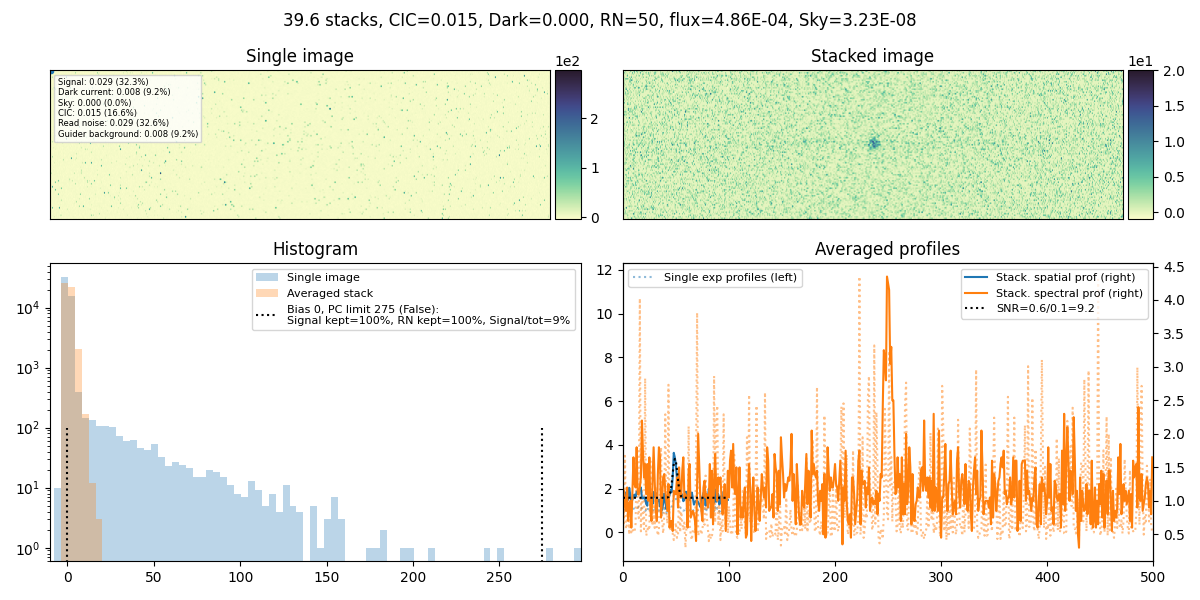

In [53]:
%matplotlib widget
%reload_ext autoreload

from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import inspect
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from functools import wraps
import inspect
import re
from scipy.sparse import dia_matrix
from scipy.interpolate import interpn
# plt.style.use('dark_background')
import functools
from scipy.optimize import curve_fit
# from pyds9plugin.DS9Utils import fitswrite
np.seterr(invalid='ignore')


#%% 
# from tools_etc import SimulateFIREBallemCCDImage
# from pyds9plugin.tools import SimulateFIREBallemCCDImage
from mpl_toolkits.axes_grid1 import make_axes_locatable
np.seterr(invalid='ignore')
import matplotlib
from matplotlib.colors import LogNorm
# from pyds9plugin.DS9Utils import PlotFit1D

import math as mt
import cmocean

def mostFrequent(arr):
    n=len(arr)
    # Insert all elements in Hash.
    Hash = dict()
    for i in range(n):
        if arr[i] in Hash.keys():
            Hash[arr[i]] += 1
        else:
            Hash[arr[i]] = 1
 
    # find the max frequency
    max_count = 0
    res = -1
    for i in Hash:
        if (max_count < Hash[i]):
            res = i
            max_count = Hash[i]
         
    return res

gaus = lambda x, a, xo, sigma, offset: a ** 2 * np.exp(-np.square((x - xo) / sigma) / 2)+ offset

#TODO add fraction kept
#TODO change flux value to good one (after convolving by PSF and size of source)
# n1,n=100,500
n2,n1=100,500
class Image(widgets.HBox):
     
    def __init__(self, exposure_time=50, acquisition_time=1, Sky_LU=4, Signal=5.57e-18, EM_gain=1400,RN=109,CIC_charge=0.005, Dard_current=0.08,readout_time=1.5,x_axis='Spectra 0044p030',counting_mode=False,smearing=0.7,guider_noise=0,PSF_RMS_mask=2.5,PSF_RMS_det = 3.5,QE=0.45,cosmic_ray_loss_per_sec=0.005,threshold=5.5,readout_sequence="1: 0.02 ADU/e-, FW=2.1 KADU"):#,conv_gain=0.2,full_well=40000):
        super().__init__()
        self.output = widgets.Output()
        self.guider_noise=guider_noise
        self.colors= ['#E24A33','#348ABD','#988ED5','#FBC15E','#8EBA42','#FFB5B8','#777777']

        args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
        if "Spectra m" in x_axis:
            Signal = float(x_axis.split("=")[-1])
            psf_source = 0.1
        else:
            psf_source = 4
        ros_number, conv_gain, full_well = np.array(re.findall(r'[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?', readout_sequence),dtype=float)

        new = Observation(exposure_time=exposure_time,Sky_LU=Sky_LU, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,guider_noise=self.guider_noise,PSF_RMS_mask=PSF_RMS_mask,PSF_RMS_det=PSF_RMS_det,QE=QE,cosmic_ray_loss_per_sec=cosmic_ray_loss_per_sec,psf_source=psf_source)
        sky = np.unique(new.sky)[0]/exposure_time
        flux = np.unique(new.Signal_el)/exposure_time

        self.im,self.im_stack, self.cube_stack, self.im0, _ = SimulateFIREBallemCCDImage(EmGain=EM_gain, Bias=0, RN=RN, p_pCIC=CIC_charge, p_sCIC=0, Dark=(Dard_current+guider_noise)/3600, Smearing=smearing, SmearExpDecrement=50000, exposure=exposure_time, flux=flux, sky=sky, source=x_axis, Rx=PSF_RMS_det, Ry=PSF_RMS_det, size=[n1, n2], OSregions=[0, max(n2,n1)], name="Auto", spectra="-", cube="-", n_registers=604, save=False,readout_time=readout_time,stack=int(new.N_images_true),QE=QE,conv_gain=conv_gain)
        # self.im0,self.im_stack,self.im = SimulateFIREBallemCCDImage(EmGain=EM_gain, Bias=0, RN=RN, p_pCIC=CIC_charge, p_sCIC=0, Dark=(Dard_current+guider_noise)/3600, Smearing=smearing, SmearExpDecrement=50000, exposure=exposure_time, flux=flux, sky=sky, source='fesc=10%, slit=100mu, w=204', Rx=5, Ry=5, size=[100, 100], OSregions=[0, 100], name="Auto", spectra="-", cube="-", n_registers=604, save=False,readout_time=readout_time,stack=int(new.N_images_true))
        # self.im_stack=self.im_stack/self.im
        self.current_cmap = cmocean.cm.deep# current_cmap = cmocean.cm.solar# self.current_cmap = cmocean.cm.thermal
        

        self.current_cmap.set_bad(color='black')
        self.bins=np.arange(-100,4000,100)
        self.bins=np.linspace(-100,np.nanmax(self.im),100)
        
        self.mod = mostFrequent(self.cube_stack[:,:20,:].flatten())
        self.limit = self.mod+threshold*RN


        self.fig, ((self.ax,self.ax0),(self.ax2,self.ax1))  = plt.subplots(2,2,figsize=(12,6), gridspec_kw={'height_ratios': [0.5, 1]})#Nominal.PlotNoise()

        if counting_mode:
            stacked_image = np.nansum(self.cube_stack>self.limit,axis=0)
            im0 = self.ax0.imshow(stacked_image, aspect="auto",cmap=self.current_cmap)
        else:
            im0 = self.ax0.imshow(self.im_stack, aspect="auto",cmap=self.current_cmap)

        # import matplotlib.gridspec as gridspec
        # self.fig =  plt.figure(figsize=(12,8))
        # gs = self.fig.add_gridspec(3, 11)
        # self.ax  = self.fig.add_subplot(gs[:2, :5])
        # self.ax0 = self.fig.add_subplot(gs[:2, 5:10])
        # self.ax1 = self.fig.add_subplot(gs[2:, :5])
        # self.ax2 = self.fig.add_subplot(gs[2:, 5:10])
        # self.ax3 = self.fig.add_subplot(gs[:, 10])
        # self.ax3.stackplot([1,2],new.electrons_per_pix[:2,:].T,alpha=0.7,colors=self.colors)
        im = self.ax.imshow(self.im, aspect="auto",cmap=self.current_cmap)#, norm=LogNorm())
        labels =  ['%s: %0.3f (%0.1f%%)'%(name,getattr(new,"electrons_per_pix")[new.i,j],100*getattr(new,"electrons_per_pix")[new.i,j]/np.sum(getattr(new,'electrons_per_pix')[new.i,:])) for j,name in enumerate(new.names)]
        self.ax.plot(0,0,".",label="\n".join(labels))
        self.ax.legend(loc="upper left",handlelength=0, handletextpad=0, fancybox=True,markerscale=0,fontsize=6)
        # self.ax.text(0,0,"\n".join(labels))
        im2=self.ax0.imshow(self.im_stack, aspect="auto",cmap=self.current_cmap)#, norm=LogNorm())
        self.ax0.get_xaxis().set_ticks([])
        self.ax0.get_yaxis().set_ticks([])
        self.ax.get_xaxis().set_ticks([])
        self.ax.get_yaxis().set_ticks([])
        self.ax.set_title('Single image')
        self.ax0.set_title('Stacked image')
        self.ax1.set_title('Averaged profiles')
        self.ax2.set_title('Histogram')
        self.l1 = self.ax1.plot(self.im[:,45:-45].mean(axis=1),':',label='Single exp profiles (left)',alpha=0.5)
        self.l2 = self.ax1.plot(self.im[40:-40,:].mean(axis=0),':',alpha=0.5)
        self.ax1bis = self.ax1.twinx()

        self.profile = np.mean(im0.get_array().data[:,45:-45],axis=1)
        if "Spectra m=" not in x_axis:
            self.ax1.lines[0].set_ydata(self.profile)
            self.ax1.lines[1].set_ydata(self.im[40:-40,:].mean(axis=0)) # spectral direction, only if not spectra
            self.l1_s = self.ax1bis.plot(self.profile,label='Stack. spatial prof (right)',c=self.l1[0].get_color())
            self.l2_s = self.ax1bis.plot(self.im_stack[40:-40,:].mean(axis=0),label='Stack. spectral prof (right)',c=self.l2[0].get_color())
        else:
            spatial_profile = self.im[:,:].mean(axis=1)
            self.ax1.lines[0].set_ydata(np.convolve(spatial_profile,3,mode="same"))
            self.profile = np.mean(im0.get_array().data[:,:],axis=1)
            self.l1_s = self.ax1bis.plot(self.profile,label='Stack. spatial prof (right)',c=self.l1[0].get_color())
            self.l2_s = self.ax1bis.plot(self.im_stack[40:-40,:].mean(axis=0),label='Stack. spectral prof (right)',c=self.l2[0].get_color())
        try:
            self.popt, self.pcov = curve_fit(gaus,np.arange(len(self.profile)),self.profile,p0=[self.profile.ptp(), 50, 5, self.profile.min()])
        except RuntimeError:
            self.popt = [0,0,0,0]

        # self.fit = PlotFit1D(x= np.arange(len(self.profile)),y=self.profile,deg="gaus", plot_=False,ax=self.ax1bis,c="k",ls=":",P0=[self.profile.ptp(), 50, 5, self.profile.min()])
        self.ax1bis.plot( np.arange(len(self.profile)),gaus( np.arange(len(self.profile)),*self.popt),":k",label="SNR=%0.1f/%0.1f=%0.1f"%(self.popt[0]**2,self.profile[:20].std(),self.popt[0]**2/self.profile[:20].std()))

        self.ax1.set_xlim((0,n1))
        self.ax1.legend(loc='upper left',fontsize=8)
        self.ax1bis.legend(loc='upper right',fontsize=8)
        _,_,self.bars1 = self.ax2.hist(self.im.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l1[0].get_color(),label='Single image')
        _,_,self.bars2 = self.ax2.hist(self.im_stack.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l2[0].get_color(),label='Averaged stack')
        title = 'Signal kept=%i%%, RN kept=%i%%, Signal/tot=%i%%'%(100*new.Photon_fraction_kept[0], 100*new.RN_fraction_kept[0],100*(np.mean(self.im_stack[40:-40,:])-np.mean(self.im_stack[:20,:]))/np.mean(self.im_stack[40:-40,:]))
        self.ax2.plot([self.mod,self.mod],[0,100],c="k",ls=":",label="Bias %i, PC limit %i (%s):\n%s"%(self.mod,self.limit, counting_mode, title))
        self.ax2.plot([self.limit,self.limit],[0,100],c="k",ls=":")#,label="PC limit %i: %s"%(self.limit, title))

                      
        self.ax2.legend(loc='upper right',fontsize=8,)
        self.ax2.set_xlim(xmin=-10, xmax=self.bins.max())
        self.cax = make_axes_locatable(self.ax).append_axes('right', size='5%', pad=0.05)
        self.cax0 = make_axes_locatable(self.ax0).append_axes('right', size='5%', pad=0.05)
        self.cbar1 = self.fig.colorbar(im, cax=self.cax, orientation='vertical')
        self.cbar2 = self.fig.colorbar(im2, cax=self.cax0, orientation='vertical')
        self.cbar1.formatter.set_powerlimits((0, 0))
        self.cbar2.formatter.set_powerlimits((0, 0))
        self.fig.canvas.toolbar_position = 'bottom'

        title = '%0.1f stacks, CIC=%0.3f, Dark=%0.3f, RN=%i, flux=%0.2E, Sky=%0.2E'%(new.N_images_true,CIC_charge,Dard_current/3600,RN,flux,sky)

        self.fig.suptitle(title)

        self.fig.tight_layout()
        style={}
        width = '400px'
        continuous_update=False

        self.reset = widgets.Button(value=False,description='↺',disabled=False,button_style='',tooltip='Reset values', layout=Layout(width="40px"))

        self.exposure_time = widgets.IntSlider( min=1, max=250,value=exposure_time, layout=Layout(width=width),description='Texp (s)',continuous_update=continuous_update,tooltip="Single frame exposure time in seconds")
        self.acquisition_time = widgets.FloatSlider( min=0.02, max=8,value=acquisition_time, layout=Layout(width=width),description='Taq (h)',continuous_update=continuous_update,tooltip="Total acquisition time in hours")
        self.Sky_LU = widgets.FloatLogSlider( min=1, max=7,value=10**Sky_LU,base=10, style =style, layout=Layout(width=width),description='Sky (LU)',continuous_update=continuous_update,tooltip="Level of sky background illumination in line units")#4



        self.EM_gain = widgets.IntSlider( min=1, max=2000,value=EM_gain, style = style, layout=Layout(width=width),description='EM gain',continuous_update=continuous_update,tooltip="EMCCD amplification gain in e-/e-")
        self.RN = widgets.IntSlider( min=0, max=120,value=RN, style = style, layout=Layout(width=width),description='Read noise',continuous_update=continuous_update,tooltip="EMCCD readout noise in electrons")
        self.CIC_charge = widgets.FloatSlider( min=0, max=0.05,value=CIC_charge,style = style, layout=Layout(width=width),description='CIC charge',step=0.001,readout_format='.3f',continuous_update=continuous_update,tooltip="EMCCD spurious charges due to amplification in electrons")
        self.Dard_current = widgets.FloatSlider( min=0, max=5,value=Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f',continuous_update=continuous_update,tooltip="Dark current of the EMCCD in electrons per hour")
        self.readout_time = widgets.FloatSlider( min=0, max=20,value=readout_time, style = style, layout=Layout(width=width),description=r'RO time (s)',step=0.1,continuous_update=continuous_update,tooltip="Readout time of the EMCCD controller in seconds")
        self.x_axis = widgets.Dropdown(options=["Spectra 1538p477 NUV~16.6","Spectra 1821p643 NUV~14",'Spectra 0044p030 NUV~16.5',"Spectra mrk509","Spectra 2344p092","Spectra 1637p574","Spectra 1115p080","Spectra 0414m060","Spectra 0115p027","Spectra 2251p113","Spectra 2201p315","Spectra 1928p738","Spectra 1700p518",'fesc=10%, slit=100mu, w=204','fesc= 1%, slit=100mu, w=204','Spectra mNUV=7','Spectra mNUV=10','Spectra mNUV=11','Spectra mNUV=12','Spectra mNUV=14','Spectra mNUV=15','Spectra mNUV=15','Spectra mNUV=16','Spectra mNUV=17','Spectra mNUV=17.5','Spectra mNUV=18','Spectra mNUV=19','Spectra mNUV=20','Spectra mNUV=22','Spectra mNUV=24','fesc=10%, slit= 50mu, w=204','fesc= 1%, slit= 50mu, w=204','fesc=10%, slit=300mu, w=204','fesc= 1%, slit=300mu, w=204','fesc=10%, slit=100mu, w=200','fesc=10%, slit= 50mu, w=200','fesc=10%, slit=300mu, w=200','fesc=10%, slit=100mu, w=208','fesc=10%, slit= 50mu, w=208','fesc=10%, slit=300mu, w=208'], layout=Layout(width='350px'),description='Entry',value=x_axis)
        #PN K 1-16 13.5
        # PG0044+030 16.5
        # IRAS 18216+6418  14
        self.readout_sequence = widgets.Combobox(options=["1: 0.02 ADU/e-, FW=2.1 KADU","1': 0.4 ADU/e-, FW=40 KADU","2: 0.04 ADU/e-, FW=4.7 KADU","2018: 0.5 ADU/e-, FW=56 KADU","2022: 0.2 ADU/e-, FW=22 KADU","2023_noOS: 0.04 ADU/e-, FW=39 KADU"], layout=Layout(width='350px'),description='RO seq',value=readout_sequence,continuous_update=False)
        # self.readout_sequence = widgets.Combobox(options=["1: 42 ADU/e-, FW=2.1 KADU","1': 2.3 e-/ADU, FW=40 KADU","2: 22 e-/ADU, FW=4.7 KADU","2018: 1.8 e-/ADU, FW=56 KADU","2022: 4.5 e-/ADU, FW=22 KADU"], layout=Layout(width='350px'),description='RO seq',value="1: 42 e-/ADU, FW=2.1 KADU",continuous_update=False)
        self.units = widgets.Dropdown(options=["ADU/frame","e-/frame","photons/frame","e-/hour","photons/hour"], layout=Layout(width='350px'),description='Units',value="ADU/frame")# TODO add ergs/cm2/...
        self.fraction_lya = widgets.FloatSlider( min=0, max=0.2,value=0.05,style = style, layout=Layout(width=width),description='Lya fraction',step=0.001,readout_format='.2f',tooltip="Fraction of E(Lya)/E(NUV)")
        # self.conv_gain = widgets.FloatSlider( min=0.02, max=1,value=conv_gain, style = style, layout=Layout(width=width),description=r'Cgain',step=0.01,continuous_update=continuous_update,tooltip="Conversion gain in ADU per e-")
        # self.full_well = widgets.FloatSlider( min=2000, max=60000,value=full_well, style = style, layout=Layout(width=width),description=r'Full well',step=0.01,continuous_update=continuous_update,tooltip="Full well in ADU (max number of ADU per pixel per frame)")

        self.fwhm = widgets.FloatRangeSlider( min=0.1, max=6,value=(PSF_RMS_mask,PSF_RMS_det),style = style, layout=Layout(width=width),description='Pre/post Mask σ',step=0.1,readout_format='.1f',tooltip="Spatial/Spectral resolution in arcseconds respectively before the spectrgraph (guidance+LO+FC) and of the spectragraph. To be multiplied by 2.35 to have the FWHM.")
        self.QE = widgets.FloatSlider( min=0, max=1,value=new.QE,style = style, layout=Layout(width=width),description='QE',step=0.01,readout_format='.2f',tooltip="EMCCD quantum efficiency in percents")
        self.guider_noise = widgets.FloatSlider( min=0, max=5,value=guider_noise,style = style, layout=Layout(width=width),description='Guider noise',step=0.2,readout_format='.1f',tooltip="Guider induced background level in electrons per hour")

        self.counting_mode = widgets.Checkbox(value=counting_mode,description='Counting',disabled=False,tooltip="Check this box to apply thresholding photon counting processing. The efficiency of this process is determined by the gain, read noise, smearing, flux.",layout=Layout(width="187px"))

        self.QElambda = widgets.Checkbox(value=True,description='QE(λ)',disabled=False,tooltip="Check this box to apply λ QE dependancy",layout=Layout(width="147px"))
        self.atmlambda = widgets.Checkbox(value=True,description='atm(λ)',disabled=False,tooltip="Check this box to apply λ atm transmission dependancy",layout=Layout(width="217px"))
        # smearing = widgets.FloatSlider( min=0, max=1.5,value=0.7, layout=Layout(width='500px'),description='CTE not yet',step=0.001)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')

        def reset(_):
            # for name in ["exposure_time","acquisition_time","Sky_LU","Signal","EM_gain","RN","CIC_charge","smearing","Dard_current","readout_time","x_axis","counting_mode","smearing","guider_noise","QE"]:
            #     rsetattr(self, '%s.value'%(name), locals_[name]) 
            self.readout_time.value = self.readout_time.value - 0.001
            # self.update()
            pass
        self.reset.on_click(reset)

        
        self.threshold = widgets.FloatSlider( min=-1.1, max=30.1,value=5.5, style = style, layout=Layout(width="347px"),description='Threshold',continuous_update=continuous_update,readout_format='.1f',step=0.1,tooltip="Threshold (n) used when photon counting mode: T=bias+nσ.")
        self.threshold.layout.visibility ='hidden'
        # self.counting_mode.layout.visibility = 'hidden'
        self.smearing = widgets.FloatSlider( min=0, max=2,value=smearing, layout=Layout(width=width),description='Smearing',step=0.01,continuous_update=continuous_update)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')      
#         self.smearing.layout.visibility = 'hidden'
    
        # wids = widgets.interact(self.update,x_axis=x_axis,counting_mode=False,exposure_time=exposure_time,Sky_LU=Sky_LU,acquisition_time=acquisition_time,Signal=Signal,EM_gain=EM_gain,RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, readout_time=readout_time)
        wids = widgets.interactive(self.update,x_axis=self.x_axis,smearing=self.smearing,counting_mode=self.counting_mode,exposure_time=self.exposure_time,Sky_LU=self.Sky_LU,acquisition_time=self.acquisition_time,EM_gain=self.EM_gain,RN=self.RN, CIC_charge=self.CIC_charge, Dard_current=self.Dard_current, readout_time=self.readout_time,fwhm = self.fwhm,QE=self.QE, guider_noise=self.guider_noise,threshold=self.threshold,QElambda=self.QElambda,atmlambda=self.atmlambda,readout_sequence=self.readout_sequence,units=self.units,fraction_lya=self.fraction_lya)#,reset=self.reset)#,Signal=self.Signal,conv_gain=self.conv_gain, full_well=self.full_well
        # controls = VBox([HBox([self.x_axis,self.reset,self.threshold,self.counting_mode,self.QElambda,self.atmlambda]),   HBox([self.Sky_LU,self.EM_gain,self.smearing])     ,  HBox([self.acquisition_time,self.Dard_current,self.CIC_charge]),    HBox([self.exposure_time,self.RN,self.readout_time]) , HBox([self.fwhm, self.guider_noise, self.QE]) , HBox([self.readout_sequence, self.units, self.fraction_lya])] )#self.conv_gain, self.full_well
        controls = VBox([HBox([self.x_axis,self.reset,self.readout_sequence, self.units]),   HBox([self.Sky_LU,self.EM_gain,self.smearing])     ,  HBox([self.acquisition_time,self.Dard_current,self.CIC_charge]),    HBox([self.exposure_time,self.RN,self.readout_time]) , HBox([self.fwhm, self.guider_noise, self.QE]) , HBox([ self.fraction_lya,self.counting_mode,self.atmlambda,self.QElambda,self.threshold])] )#self.conv_gain, self.full_well
        #self.threshold,self.counting_mode,self.QElambda,self.atmlambda
        display(HBox([self.output,controls]))

# TODO add the conversion gain the calculus of magnitude        

    def update(self, x_axis,counting_mode,Sky_LU,acquisition_time,EM_gain,RN,CIC_charge,Dard_current,readout_time,exposure_time,smearing,fwhm,QE,guider_noise,threshold,QElambda,atmlambda, readout_sequence,units, fraction_lya,cosmic_ray_loss_per_sec=0.005):#,reset=0):#Signal,conv_gain,full_well,
        """Draw line in plot"""
        # from pyds9plugin.tools import SimulateFIREBallemCCDImage
        # from tools_etc import SimulateFIREBallemCCDImage



        with self.output:
            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
#             title='Gain=%i, Texp=%i, CIC=%0.3f, Dark=%0.3f, RN=%i, Signal=%0.2E, Sky=%0.2E, e-/pix=%0.2E'%(EM_gain,exposure_time,CIC_charge,Dard_current,RN,Signal,Sky_LU,self.el_per_pix)
#             value = locals_[x_axis]
            if "Spectra m=" in x_axis:
                Signal = float(x_axis.split("=")[-1])
                psf_source = 0.1
                self.fraction_lya.layout.visibility = 'visible'
            else: 
                Signal = 20
                psf_source = 4
                self.fraction_lya.layout.visibility = 'hidden'
            if counting_mode:
                self.threshold.layout.visibility = 'visible'
            else:
                self.threshold.layout.visibility = 'hidden'
            new = Observation(exposure_time=exposure_time,Sky_LU=Sky_LU, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,guider_noise=guider_noise,QE=QE,psf_source=psf_source)
            sky = np.unique(new.sky)[0]/exposure_time
            flux = np.unique(new.Signal_el)/exposure_time
            ros_number, conv_gain, full_well = np.array(re.findall(r'[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?', readout_sequence),dtype=float)
            # conv_gain = 1/conv_gain
            full_well *= 1000

            self.im,self.im_stack, self.cube_stack,self.im0,_  =  SimulateFIREBallemCCDImage(EmGain=EM_gain, Bias=0, RN=RN, p_pCIC=CIC_charge, p_sCIC=0, Dark=(Dard_current+guider_noise)/3600, Smearing=smearing, SmearExpDecrement=50000, exposure=exposure_time, flux=flux, sky=sky, source=x_axis, Rx=fwhm[-1], Ry=np.sqrt(fwhm[-1]**2 + fwhm[0]**2), size=[n1, n2], OSregions=[0, max(n2,n1)], name="Auto", spectra="-", cube="-", n_registers=604, save=False,stack=int(new.N_images_true),readout_time=readout_time,QE=QE,QElambda=QElambda,atmlambda=atmlambda,conv_gain=conv_gain,fraction_lya=fraction_lya)
            self.im[self.im>full_well] = np.nan
            self.current_cmap.set_bad('red',1.)
            if units=="ADU/frame": #ADU/frame: ok basic
                factor=1
            elif units=="e-/frame": #e-/frame: divide by conversion gain and amplification gain
                factor=1/conv_gain/EM_gain
            elif units=="photons/frame": #photons/frame: account for QE
                factor=1/conv_gain/EM_gain/QE
            elif units=="e-/hour": #e-/hour: divide by exptime
                factor=1/conv_gain/EM_gain/3600
            elif units=="photons/hour": #photons/hour: divide by exptime, account for QE
                factor=1/conv_gain/EM_gain/QE/3600

            im = self.ax.imshow(self.im*factor, aspect="auto",cmap=self.current_cmap)
            self.mod = mostFrequent(self.im_stack[:20,:].flatten())
            self.limit = self.mod+threshold*RN

            if counting_mode:
                stacked_image = np.nansum(self.cube_stack>self.limit,axis=0)
                im0 = self.ax0.imshow(stacked_image, aspect="auto",cmap=self.current_cmap)
            else:
                im0 = self.ax0.imshow(self.im_stack*factor, aspect="auto",cmap=self.current_cmap)
            self.cbar1 = self.fig.colorbar(im, cax=self.cax, orientation='vertical')
            self.cbar2 = self.fig.colorbar(im0, cax=self.cax0, orientation='vertical')
            self.cbar1.formatter.set_powerlimits((0, 0))
            self.cbar2.formatter.set_powerlimits((0, 0))

            labels =  ['%s: %0.3f (%0.1f%%)'%(name,getattr(new,"electrons_per_pix")[new.i,j],100*getattr(new,"electrons_per_pix")[new.i,j]/np.sum(getattr(new,'electrons_per_pix')[new.i,:])) for j,name in enumerate(new.names)]


            # self.profile = np.mean(im0.get_array().data[:,45:-45],axis=1)


            if "Spectra m=" not in x_axis:
                self.ax1.lines[0].set_ydata(self.im[:,45:-45].mean(axis=1))
                stacked_profile = np.mean(im0.get_array().data[:,45:-45],axis=1)
                self.ax1.lines[1].set_ydata(self.im[40:-40,:].mean(axis=0)) # spectral direction, only if not spectra
                self.ax1bis.lines[1].set_ydata(np.mean(im0.get_array().data[40:-40,:],axis=0))
                self.ax.lines[0].set_label(" ")                 
            else:
                # self.profile = np.mean(im0.get_array().data[:,:],axis=1)
                stacked_profile = np.mean(im0.get_array().data[:,:],axis=1)
                # print(x_axis)
                spatial_profile = self.im[:,:].mean(axis=1)
                self.ax1.lines[0].set_ydata(np.convolve(spatial_profile,3,mode="same"))
                self.ax1bis.lines[1].set_ydata(np.mean(im0.get_array().data[40:-40,:],axis=0))
                self.ax1.lines[1].set_ydata(self.im[40:-40,:].mean(axis=0)) 
                self.ax.lines[0].set_label("  \n".join(labels))
            self.ax.legend(loc="upper left",handlelength=0, handletextpad=0, fancybox=True,markerscale=0,fontsize=8)
    
            try:
                self.popt, self.pcov = curve_fit(gaus,np.arange(len(stacked_profile)),stacked_profile,p0=[stacked_profile.ptp(), 50, 5, stacked_profile.min()])
            except RuntimeError:
                self.popt = [0,0,0,0]
            # self.fit = PlotFit1D(x= np.arange(len(stacked_profile)),y=stacked_profile,deg="gaus", plot_=False,ax=self.ax1bis,c="k",ls=":",P0=[stacked_profile.ptp(), 50, 5, stacked_profile.min()])
            self.ax1bis.lines[0].set_ydata(stacked_profile)
            self.SNR = self.popt[0]**2/stacked_profile[:20].std()
            self.Flux_ADU =  np.sum(gaus( np.arange(len(stacked_profile)),*self.popt)-self.popt[-1]) 
            # self.Flux_ADU_counting =  np.sum(-np.log(1-( self.fit["function"]( np.arange(len(stacked_profile)),*self.fit["popt"])-self.fit["popt"][-1] )/(np.exp(-threshold*RN/EM_gain))))
            self.e_s_pix = self.Flux_ADU * new.dispersion / exposure_time / new.N_images_true/conv_gain  if counting_mode else  self.Flux_ADU * new.dispersion / EM_gain / exposure_time/conv_gain
            self.flux = self.e_s_pix / new.Throughput/ new.Atmosphere / QE / new.area
            photon_energy_erg = 9.93e-12
            self.mag = -2.5*np.log10(self.flux*photon_energy_erg/(2.06*1E-16))+20.08
            self.ax1bis.lines[2].set_label("SNR=%0.2f/%0.2f=%0.1f, mag=%0.2f"%(self.popt[0]**2,stacked_profile[:20].std(),self.SNR ,self.mag))
            # ,label="SNR=%0.1f/%0.1f=%0.1f"%(self.popt[0]**2,self.profile[:20].std(),self.popt[0]**2/self.profile[:20].std()))
            self.ax1bis.lines[2].set_ydata(gaus( np.arange(len(stacked_profile)),*self.popt))
            self.ax1bis.legend(loc="upper left",fontsize=8)

            self.ax1.relim()
            self.ax1.autoscale_view()
            self.ax1bis.relim()
            self.ax1bis.autoscale_view()

            # for patch in self.ax2.patches:
            #     patch.clear()
            # self.ax2.cla()
            [b.remove() for b in self.bars2]
            [b.remove() for b in self.bars1]
            _,_,self.bars1 = self.ax2.hist(self.im.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l1[0].get_color(),label='Single image')
            _,_,self.bars2 = self.ax2.hist(self.im_stack.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l2[0].get_color(),label='Averaged stack')
            # self.fig.axes[3].patches.clear()
            # self.fig.axes[3].hist(self.im.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l1[0].get_color(),label='Single image')
            # self.fig.axes[3].hist(self.im_stack.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l2[0].get_color(),label='Averaged stack')

            self.ax2.legend(loc='upper right',fontsize=8)
            self.ax2.lines[0].set_xdata([self.mod,self.mod])
            self.ax2.lines[1].set_xdata([self.limit,self.limit])
            # title = 'Signal kept=%i%%, RN kept=%i%%\n'%(100*new.Photon_fraction_kept[0], 100*new.RN_fraction_kept[0])
            title = 'Signal kept=%i%%, RN kept=%i%%, Signal/tot=%i%%'%(100*new.Photon_fraction_kept[0], 100*new.RN_fraction_kept[0],100*(np.mean(self.im_stack[40:-40,:])-np.mean(self.im_stack[:20,:]))/np.mean(self.im_stack[40:-40,:]))
            self.ax2.lines[0].set_label("Bias %i, PC limit %i (%s):\n%s "%(self.mod,self.limit, counting_mode, title))
            # self.ax2.set_xlim(xmax=)       
            self.ax2.legend(fontsize=8,loc="upper right")
            title = '%0.1f stacks, CIC=%0.3f, Dark=%0.3f, RN=%i, Flux=%0.2E, Sky=%0.2E'%(new.N_images_true,CIC_charge,Dard_current/3600,RN,flux,sky)
            # title = '%0.1f stacks, Noise(e-/frame): CIC=%0.3f, Dark=%0.3f, RN=%i, Flux=%0.2E, Sky=%0.2E'%(new.N_images_true,CIC_charge**2,(Dard_current*exposure_time/3600)**2,RN,flux,sky)
            self.fig.suptitle(title)
            self.fig.canvas.draw()
            # fitswrite(self.im, "/tmp/test_%s.fits"%(fwhm[1]))




ETC = Image(EM_gain=1700,RN=50, CIC_charge=0.015, smearing=0.4,Dard_current=0.5,readout_time=3,exposure_time=60,counting_mode=False,Sky_LU=4.5,guider_noise=0.5,PSF_RMS_mask=2.8,PSF_RMS_det = 2.9,QE=0.55,x_axis="Spectra mNUV=20",)#Spectra 1821p643
 
# 2018
# ETC = Image(EM_gain=1400,RN=110, smearing=0.8,Dard_current=0.5,counting_mode=False,Sky_LU=5.5,guider_noise=1,PSF_RMS_mask=1.8,PSF_RMS_det = 2.8,QE=0.55)
# verif flux:
# ETC = Image(EM_gain=1,RN=0, smearing=0,Dard_current=0,counting_mode=False,Sky_LU=4,guider_noise=0,PSF_RMS_mask=0.1,PSF_RMS_det = 0.1,QE=1,CIC_charge=0)

#No imncoming photons
# ETC = Image(EM_gain=2000,RN=0, smearing=0.4,Dard_current=0,counting_mode=False,Sky_LU=1,guider_noise=0,PSF_RMS_mask=1.8,PSF_RMS_det = 2.8,QE=0.55,x_axis="Spectra m=24",CIC_charge=0)#Spectra 1821p643


<!-- # <center>FIREBall-2 SNR calculator </center>

### Explanation
- Gives the estimated signal-to-noise ratio for an extended source on a resolution element
- **Variables:** Source's flux, sky, aquisition time, exposure time, EM gain, dark current, CIC, readnoise, readout time, thresholding, smearing exponential length and temperature if you check it (based on a first rough evolution of smearing and dark current with temperature, therefore changing the temperature will change smearing and dark accordingly.)
- **Fixed Values:** QE = 45%, resolution element=57 mu, pixel_size = 13 mu, throughput = 13%, atmosphere transmission = 50%
- **Outputs:** In the top pannel, the noise of the different sources (Signal, Dark, Sky, CIC, RN) is given in e- per resolution element per N frames on the total acquisition time. The middle pannel we give the average e-/pix value for each component (before stacking). We give the relative fraction of all sources of noise and the resulting SNR. When thresholding is applied, the smearing can be changed as it will impact the position of the threshold that optimizes the SNR. For this optimal threshold, the fraction of signal and readnoise kept (above the threshold) is given.
- **Caution:**  it appears that for EMCCDs the dependencies are pretty complex/non-linear. In particular, the lack of models on the impact of amplification, thresholding, and register clearing... combined with smearing on the final SNR makes risky the fact of relying only on modeling to choose the optimal temperature/gain/etc. That's why I suggest an [end-to-end test](https://docs.google.com/document/d/1SpiEK8MBmYduKUFvWmnTOfkfsX4VWs6JMF5-YJKDELo/edit?usp=sharing) validating this: 


### Analysis
- **Smearing:** At -120C, the low device's CTE smears the pixels' counts and then lowers the effective gain. This lowering factor is huge (>2) for a smearing length of 1.5, but is much smaller for a smearing length of 0.7 (~1.2). 
It seems that we already had a comparabale 0.7 smearing length with previous controller at 10MHz (tests February 7th and 8th 2019) at same EMgain (1600) and temperature (-95C). Which might mean that the 1MHz reading does not decrease significantly the smearing. **With the current (2022) smearing length, thresholding does not increase the SNR!! If we manage to invert the smearing, even if it doubles the readnoise, we could recover most of the thresholding efficiency.**
- **Photon-counting:** The thresholding effect can be misleading as it depends on Flux, EMgain, RN, smearing and noise($\sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2$). But actually it depends mostly on the ratio $\frac{G_{EM,eff}}{RN}$. For a ratio >> 10 the thresholding is efficient. As stated above for a smearing length of 0.7, EMgain and effective_gain are close. A consequence of that, is that at the EMgains we use ($\sim1600$) and smearing $\sim 0.7$, the thresholding is almost as efficient with RN=50 and RN=107 as the ratio $\frac{G_{EM,eff}}{RN}$ stays >>10. This was not the case in 2018 when the smearing length was 1.5. This is why in photon counting mode, you will see a very small impact of read noise change.
- **Reading frequency tradeoff:** Based on above, the change from 10MHz to 1MHz as minor consequences on the total SNR.
    - In photon counting mode and with low smearing, the decrease of the RN has quasi no effect (~1%) on the SNR
    - The transition from 1.4 to 3sec readout would mean a loss of SNR of ~2%, transition to 10sec about ~10% 
    - Therefore the real critical point is the possible need to add or not a shutter above the tank with the 1MHz controller as it will complexify guidance
- **Temperature Tradeoff:** Conclusion depends on the definition of SNR on thresholded images (see below): In both cases, the SNR decreases with smearing but in one case smearing has more important impact and compensate  dark current giving rise to an optimal temperature. Though, the fact that we will never get rid of dark current while we could actually manage to inverse the smearing could suggest staying at low temperature (-120 to -110).

 
  
  
|             **Parameters**             |          **2022 1Mhz controller**           | **Values 2018** |
| :------------------------------------: | :-----------------------------------------: | :-------------: |
|          **Temperature (C)**           |                     -95                     |      -115       |
|       **Conversion gain ADU/e-**       |                    1/4.5                    |      0.53       |
|           **Read noise e-**            |            50 -> 60 longer cable            |       107       |
|         **pCIC e− /pix/frame**         |                    0.003                    |      0.004      |
|         **sCIC e− /pix/frame**         |                   ~0.002                    |     ~0.002      |
|  **semi-amplified CIC e− /pix/frame**  |                    ~0.02                    |     ~0.03-4     |
|           **EM gain  e-/e-**           |          O                    2000          |      1400       |
|   **Smearing exponent. length pix**    |              L~0.6 ± 0.1  pix               |   L~1.5 ± 0.1   |
|       **Dark current e− /pix/h**       |                   ~2±0.5                    |   0.5 ± 0.03    |
| **Cosmetics % pixels bottom detector** |                     ~2%                     |   <<1% (TBD)    |
|         **Exposure time sec**          |                     50                      |       50        |
|          **Readout time sec**          | ~10 (all), ~3(physical) +2 better clearance |      ~1.4       |


<!-- 
### Need to add
- Predictions for point source, sources on several resolution element, stack of galaxies
 -->

<!-- Based on the 2019 and 2022 images the consequences of a 20 degrees increase is important. With the first approximations, the increase of the dark current combined with the decrease of the smearing length might lead to a 5% SNR increase in counting mode (+sharper PSF). Though, for now, the major consequence of the temperature increase seems to be the high fraction of cosmetics on the lower part of the image. A significant fraction could be corrected for with appropriated software but the fraction can become extremely high and prevent good correction (needs further implementation). This is not taken into account in this model. Decreasing the tempetrature to -100C (TBD) might be a good trade off (in 2019 we had 0.8 smearing at -95C and EMgain=1600). For very bright objects the shot noise becomes dominant and then the impact of dark current is smaller so the SNR peaks at higher temps (80).
 --> 

<!-- 
## Thresholding analysis
The threshold is computed by optimizing the SNR:

$$ SNR_1(T) = F_{True,pos}(T)\frac{S \times F_{e^->0,ADU>T}}{\sqrt{ F_{e^->0,ADU>T} \times(S + \sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2)  + F_{e^-=0,ADU>T} \frac{\sigma_{RN}^2}{Gain} }} 
\sim F_{True,pos}(T) \frac{S \sqrt{ F_{e^->0,ADU>T}}}{\sqrt{S + \sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2 }}$$



with:
- $\sigma_{RN}^2=\frac{RN}{G_{EM}} \times \frac{\sum RN[RN>T]}{\sum RN} = \frac{RN}{EMgain}  \times \%pix_{e^-=0}^{ADU>T}$: ie 60e-/2000 x the fraction of pixels above the threshold which dit not receive any photo-electrons 
- $ F_{e^->0,ADU>T}$ :  fraction of pixels above the threshold which received more than 0 electons
- $ F_{e^-=0,ADU>T}$ :  fraction of pixels above the threshold which did not receive any electron
- $F_{True,pos} = \frac{F_{e^->0,ADU>T}}{F_{ADU>T}} $ : the fraction of true positives = the fraction of pixels above the threshold which received more than 0 electons. This uncertainty term is not in the final SNR formula as it converges towards ~1 after stacking as the average pixel value will converge towards the real number of incoming photo-electrons

The thresholding depends on 5 factors:
- **The gain**: the higher the gain the easier it is to differentiate pixels who received a photo-electron and those which did not
- **The read noise**: the lower the RN the easier it is to differentiate pixels who received a photo-electron and those which did not
- **The low CTE** smears the charges, from pixels who did receive a photo-electron to pixel who did not and lower the effective gain $G_{EM,eff}$
- **The signal**: because thresholding only allows to recover 0 and 1, thresholding is only efficient at flux <<1e-/exp 
- **The additional noise**: $\sigma = \sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2$ has relatively small impact on the impact of the thresholding

**At the end, the thresholding impact is:**
- Highly non linear, many things to learn
- The efficiency of the thresholding depends mostly of the ratio $\frac{G_{EM,eff}}{RN}$, which extremely impacted by the smearing.
- The thresholding SNR gain (SNR$_{threshold}$/SNR$_{analogic}$) lies within $[0,\sqrt{2}]$. Condditions are pretty stricts to get som thresholding efficiency and smearing makes the upper bound falls dramatically. 
- Therefore if might not worth it to loose SNR in order to be in these very conditions as we will loose it anyway in the final budget.
- The thresholding SNR gain seems less impacted by read noise. Which means that if we manage to do some (linear?) inversion of the smearing which increases the noise, it might still increase the thresholding gain above 1. 
- The only real game changer in terms of SNR is the smearing 
- **Fraction kept (photo-electrons above threshold)**
    - Important dependance on smearing and flux, less important one on gain and read noise.
    - At low smearing the bigger the ratio gain/ron the higher the fraction of charges kept.
    - Evolution with smearing is dramatic, higher gain does not help much, lower RN helps
    - Fraction increase with flux 
- **Fraction fake detections (0e- pixels above threshold)**
    - Increases importantly with smearing
    - does not depend much on read noise (small positive correlation)
    - decreases with gain
    - Increases as Flux increase. Not sure to understand why... Maybe because the number of pixels with 0 photo-e- cecreases 
- **Thresholding SNR gain**
    - Thresholding is efficient only if >1
    - Dramatically decreases with smearing (No interest of thrsholding above smearing legth of 0.6)
    - Increases with gain and decreases with read noise if no smearing
    - if smearing, the read noise has no impact.
    - Increases with flux
- **Threshold**
    - increase extremely with smearing
    - Without smearing, poor dependance on gain and readnoise
    - If smearing, increases as readnoise decreases
    - If smearing: Increasing with gain!
    - Increases with flux

 -->

<!-- 

|   **Thresholding dependancy table**                   | **Smearing <br />  ( 0 - 2 )** | **Read noise  <br /> ( 30 - 120 )** | **Gain  <br /> ( 800 - 2500 )** | **Flux <br /> ( 0.01 - 1.5 )** |
|:--------------------:|:------------------:|:-----------------------:|:-------------------:|:------------------:|
|     **Photo-electron Fraction kept**    |    --- <br /> 92% - 66%    |       -  <br /> 72% - 71%       |     .   <br /> 72% - 71%    |     +  <br /> 75% - 76%    |
| **RN fraction kept** |  +++  <br /> 0.6% - 12.4%  |       +  <br /> 0.7% - 1%       |    -  <br /> 1.1% - 0.5%    |    ++?  <br /> 0.3% - 3%   |
|     **Threshold**    |   +++  <br /> 3 σ - 11 σ   |      --  <br /> 18 σ - 5 σ      |     + <br />  5 σ - 16 σ    |    +? <br />  8 σ - 13 σ    |
|        **Thresholding SNR gain**       |     --- <br />  1.3 - 0.6   |        --  <br /> 1.35 - 1.22        |      +  <br /> 1.13 - 1.18      |      ++  <br /> 1.16 - 1.21     |
 -->


In [23]:
# 2018, 30 images on F2
#ETC = Image(exposure_time=50, acquisition_time=0.5, Sky_LU=6, Signal=5.57e-18, EM_gain=1400,RN=109,CIC_charge=0.005, Dard_current=1,readout_time=1.5,x_axis='Spectra m=17.5', counting_mode=False,smearing=1.5,guider_noise=2,PSF_RMS_mask=2.5,PSF_RMS_det = 3.5,QE=0.45,cosmic_ray_loss_per_sec=0.005,threshold=5.5,readout_sequence="2018: 0.5 ADU/e-, FW=56 KADU")
